In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
data_root_folder='../data'
data_images_root_folder='../data/images'

# Data exploration & preprocessing

In [2]:

X_train=pd.read_csv(f'{data_root_folder}/X_train_update.csv', index_col=0)
X_test=pd.read_csv(f'{data_root_folder}/X_test_update.csv', index_col=0)
Y_train=pd.read_csv(f'{data_root_folder}/Y_train_CVw08PX.csv', index_col=0)
data=pd.concat([X_train,Y_train], axis=1 )
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  84916 non-null  object
 1   description  55116 non-null  object
 2   productid    84916 non-null  int64 
 3   imageid      84916 non-null  int64 
 4   prdtypecode  84916 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.9+ MB


* Columns types are relevant
* Data size is relevant for Machine Learning
* For the suggested X_test, Y_test is missing, the test data will be generated from the train data 

## Missing & duplicated

35% of 'description' column values are missing & 60% of 'description' are distinct

### Missing images ?

In [3]:
notfound=False
for index, row in data.iterrows():
    imgid = row['imageid']
    prdid = row['productid']
    try:
        mpimg.imread(f'{data_images_root_folder}/image_train/image_{imgid}_product_{prdid}.jpg')
    except FileNotFoundError as error:  
       notfound=True
       print('Image not found', error)
if not notfound:
    print('No image is missing')

No image is missing


### Duplicated values

In [4]:
data_descnotna=data[-data.description.isna()]
data_desc_dup=data_descnotna[data_descnotna.duplicated(['description'])].groupby('description').agg(count=('prdtypecode', 'size'),prdtypecodes=('prdtypecode',lambda x: str(x.unique()))).sort_values(by=['count'], ascending=False).query('count>30')
display(data_desc_dup)

count      prdtypecodes
description                                                                
<br>Attention !!! Ce produit est un import  si ...    251              [40]
Taille: En format A5 (144 cm x 21 cm) Caractéis...    231            [2522]
Taille: En format A5 (144 cm x 21 cm) Caracteri...    188            [2522]
Taille: En format A5 (144 cm x 21 cm) Caract?is...    161            [2522]
Taille: En format A5 (144 cm x 21 cm) Caractéri...     88            [2522]
<br />                                                 80  [1940 2522 1301]
Piscine hors-sol en acier ronde Fidji de la mar...     56            [2583]
Kit de piscine hors-sol ronde en acier Bora Bor...     38            [2583]
Faites de la place dans le jardin à la piscine ...     37            [2583]
Piscine hors-sol ovale en acier blanc Wet de la...     36            [2583]
Kit complet piscine ronde en acier Wet de la ma...     36            [2583]
Piscine hors-sol ovale en acier blanc Fidji de ...     35            [2583]
Piscine hors-sol acier blanc Haïti ovale de la ...     34            [2583]
La gamme de piscines hors sols Fusion de la mar...     33            [2583]
Lampe 3D - 7 couleurs interchangeable au choix ...     31            [2060]

- Most of duplicated values are related to one type, which sets a corrolation between that could be useful in predicting the label
- The duplicated value '\<br />' can be deleted as it doesn't bring any semantic
- The duplicated value '...Attention !!! Ce produit est un import si les informations 'langues' et 'sous-titres'...' can be deleted as well.

## Product types data exploration

### Distribution

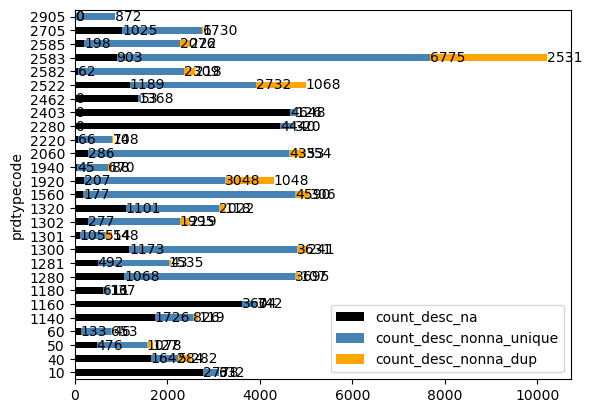

In [5]:
data_byprdtype_na=data.groupby('prdtypecode', group_keys=True).agg(count_desc_na=('description',lambda x: x.isna().sum()), count_desc_nonna_unique=('description',lambda x: (x[x.notna()].unique()).size), count_desc_nonna_dup=('description',lambda x: x[x.notna()].duplicated().sum()))
ax1=data_byprdtype_na.plot.barh(stacked=True, color=['black', 'steelblue', 'orange'])
ax1.bar_label(ax1.containers[0], labels=data_byprdtype_na['count_desc_na'])
ax1.bar_label(ax1.containers[1], labels=data_byprdtype_na['count_desc_nonna_unique'])
ax1.bar_label(ax1.containers[2], labels=data_byprdtype_na['count_desc_nonna_dup'])
plt.show();

- Product types are not evenly distributed, 2583 is an outlier 
- Need to rebalance the data, by : 
    * For types with highest counts, deleting rows with description = NA values & replacing duplicates
    * Some product types have small amount of relevant 'description', for those a strategy might be relying on the 'designation'
    * Then rebalance the rest following guidelines [here](https://medium.com/@dlikhitha99/all-methods-for-balancing-imbalanced-data-decfe1f4048d)




### Guess what's behind the product type code ?

The goal of following routine is to : 

* Identifiy to what extent the 'designation' & 'description' content are capable to relate to a product type
* What kind of data cleaning should be carried out to make text data the most relevant
* Determine the semantic behind the product type code by displaying random pictues and top keywords for each product type code, it would help in better human interpretation of results during the model experimentation.


First 20 entries for type 10


designation  \
0    Olivia: Personalisiertes Notizbuch / 150 Seite...   
6           Christof E: Bildungsprozessen Auf Der Spur   
46   Vassivière -En-Limousin.  Le Jardin Art Et Lie...   
131    Dr. Mercurius' Heilsame Reise Zum Planeten Erde   
188                               La Promenade Au Parc   
247  Loop Transfer Recovery: Analysis And Design (C...   
258   Télémaque - Je Ne Sais Quoi De Pur Et De Sublime   
259                Bleu Nuit Ou Les Sept Vies Du Moine   
300                          Nicholas: Lord Of Secrets   
335                  Physics For Science & Engineering   
372  Le Barbier De Seville Suivi De Le Mariage De F...   
386  L'avant Scene N° 190 Meurtres En Fa Diese -Sai...   
391  Entrées Solennelles De S. A. R. Monsieur (12 A...   
403  Thomas' Really Useful Word Book (Thomas The Ta...   
432                       Piano Initial 2018 / Recueil   
460                          Ich Du Und Die Ganze Welt   
477  Le Petit Guide Du Developpement Spirituel - 12...   
513               Sherwood G: Pedigree Register Vol. 2   
538  Le Management Multi-Dimensionnel. Direction - ...   
580                     In Amazonia: A Natural History   

                                           description  prdtypecode  
0                                                  NaN           10  
6                                                  NaN           10  
46                                                 NaN           10  
131                                                NaN           10  
188                                                NaN           10  
247                                                NaN           10  
258                                                NaN           10  
259                                                NaN           10  
300                                                NaN           10  
335                                                NaN           10  
372                                                NaN           10  
386                                                NaN           10  
391                                                NaN           10  
403                                                NaN           10  
432                         Piano ou Clavier / Piano -           10  
460                                                NaN           10  
477                                                NaN           10  
513                                                NaN           10  
538  Sous la pression de l'environnement économique...           10  
580                                                NaN           10

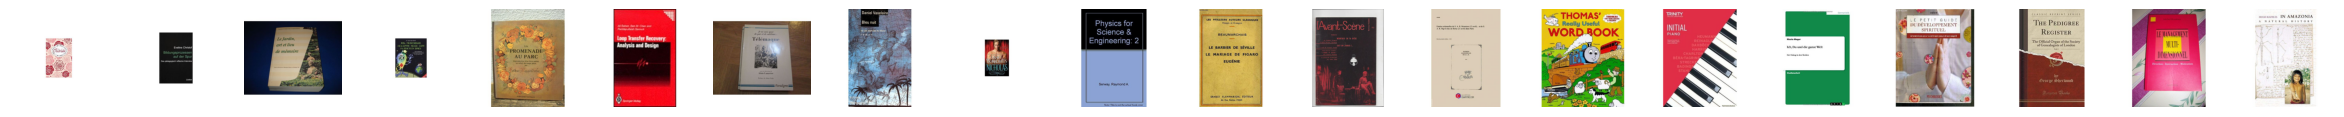

Before cleaning
Top 5 features when designation ['edition' 'france' 'guide' 'histoire' 'tome']
Top 5 features when designation+description ['br' 'edition' 'histoire' 'livre' 'tome']
After cleaning
Top 5 features when designation ['edition' 'guide' 'histoire' 'tome' 'vie']
Top 5 features when designation+description ['edition' 'guide' 'histoire' 'livre' 'tome']
-----------------------------------------------------------------------
First 20 entries for type 40


/opt/anaconda3/envs/mle-rakuten/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 'neuf', 'qu', 'quelqu', 've'] not in stop_words.
  warnings.warn(


designation  \
31                                 X-Men 3 - The Movie   
34                               The Lord Or Thé Rings   
47        Shin Masoukishin Panzer Warfare (Import Jap)   
50                              Jeu Pc Cd-Rom : Azteca   
101       Innercity Burnout [Import Allemand] [Jeu Pc]   
107  Zumba Fitness : Rush (Jeu Kinect) [Import Alle...   
142             Pokémon Saphir Alpha - Edition Limitée   
195                   King's Bounty - Armored Princess   
204  Câble Adaptateur Audio Stéréo Ordinateurs Port...   
252                      Guilty Gear X (Version Japon)   
282                     World Destruction Lea. War Jet   
332  Magideal Réparation Du Module De Capteur Analo...   
346  Assassin's Creed : Brotherhood + Assassin's Cr...   
421              Planet 51 [Import Allemand] [Jeu Wii]   
422  Magideal Coque De Console De Jeux Vidéo En Alu...   
476                     What Would We Do [In Da Soul M   
483  Mission Vétérinaire - Je Soigne Les Animaux Fa...   
506                       Wii Fit (Sans Balance Board)   
556                           Just Dance Greatest Hits   
557                            Grabbed By The Ghoulies   

                                           description  prdtypecode  
31                                                 NaN           40  
34                                                 NaN           40  
47                                                 NaN           40  
50                                                 NaN           40  
101  <br>Attention !!! Ce produit est un import  si...           40  
107  <br>Attention !!! Ce produit est un import  si...           40  
142                                                NaN           40  
195                                                NaN           40  
204  <p><b>La description:</b></p><br /><p> Le câbl...           40  
252                                                NaN           40  
282                                                NaN           40  
332  <p><b>La description:</b></p><br /><p> Pièce d...           40  
346  <br>Attention !!! Ce produit est un import  si...           40  
421  <br>Attention !!! Ce produit est un import  si...           40  
422  <p><b>La description:</b></p><br /><p> 100% to...           40  
476                                                NaN           40  
483  Mission Vétérinaire - Je Soigne Les Animaux Fa...           40  
506  <br />"Wii Fit" propose plus de 40 exercices c...           40  
556                                                NaN           40  
557  Depuis l'annonce de sa fusion avec Microsoft o...           40

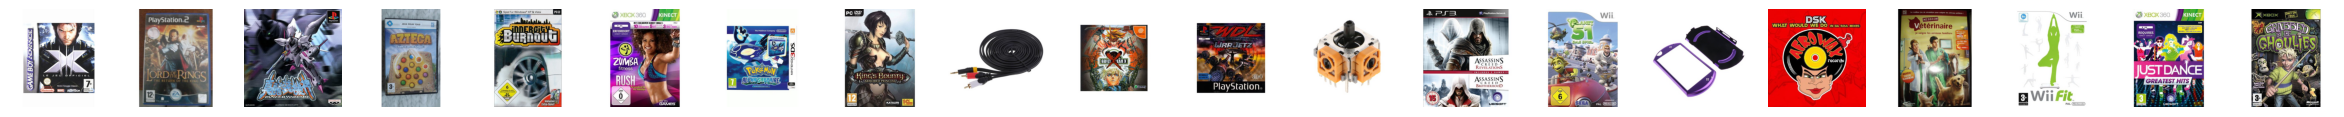

Before cleaning
Top 5 features when designation ['allemand' 'import' 'jeu' 'magideal' 'pc']
Top 5 features when designation+description ['39' 'br' 'import' 'jeu' 'li']
After cleaning
Top 5 features when designation ['edition' 'jeu' 'magideal' 'pc' 'ps']
Top 5 features when designation+description ['contrôleur' 'jeu' 'jeux' 'pc' 'ps']
-----------------------------------------------------------------------
First 20 entries for type 50


designation  \
2    Grand Stylet Ergonomique Bleu Gamepad Nintendo...   
80   Contrôleur De Jeu Mobile Tir Sensible Et But J...   
163      Fauteuil De Bureau Gaming Swift Noir Et Rouge   
165  Sony Dualshock 4 V2 - Gamepad - Sans Fil - Blu...   
207  Manette Filaire Ps3 / Pc Shockpad Ghx5ef Shock...   
211                            Volant Wii Non Officiel   
341  Qkz Vk1 Intra-Auriculaire Filaire Universal Éc...   
415  2x Batterie Rechargeable + Charge Station De C...   
424  Silicone Housse De Protection Pour Poké Ball P...   
433            Boîte De Rangement De Jeux Nintendo Nes   
481                     Ps4 Stickers Manettes Lot De 4   
486     Gelshell Wand Silicone Skin Vert Pour Htc Vive   
491  Commutateur Hôte En Caoutchouc Protection Hard...   
507  Yantos Nouveaux Chargeur 220v Sony Playstation...   
529  Contrôleur De Charge Double Usb Station De Rec...   
555           Ps4 Stickers Console Vinyl Imprimé Motif   
679            Chargeur Secteur / 3dsxl 3ds Dsi Dsi Xl   
776                  Ps3 Controller Battery (Gbooster)   
785  Chargeur Adaptateur Secteur Pour Nin Commutate...   
894  Tissu En Nylon Souple Housse De Voyage Mallett...   

                                           description  prdtypecode  
2    PILOT STYLE Touch Pen de marque Speedlink est ...           50  
80   Contrôleur de jeu mobile Tir sensible et But J...           50  
163                                                NaN           50  
165                                                NaN           50  
207  Manette filaire compatible PS3 / PC ShockPad r...           50  
211                                                NaN           50  
341  <b>Main Features:</b><br />? quatre unités coa...           50  
415  2x batterie rechargeable &#43; Charge Station ...           50  
424  Silicone Housse de protection pour Poké Ball p...           50  
433                    Boîte pour 10 jeux Nintendo Nes           50  
481                     PS4 Stickers Manettes Lot de 4           50  
486                                                NaN           50  
491  Commutateur hôte en caoutchouc Protection Hard...           50  
507                                                NaN           50  
529  Contrôleur de charge double USB Station de rec...           50  
555           PS4 Stickers Console Vinyl Imprimé Motif           50  
679                                                NaN           50  
776                                                NaN           50  
785  Chargeur adaptateur secteur pour Nin commutate...           50  
894  Tissu nylon Couverture souple Voyage étui de t...           50

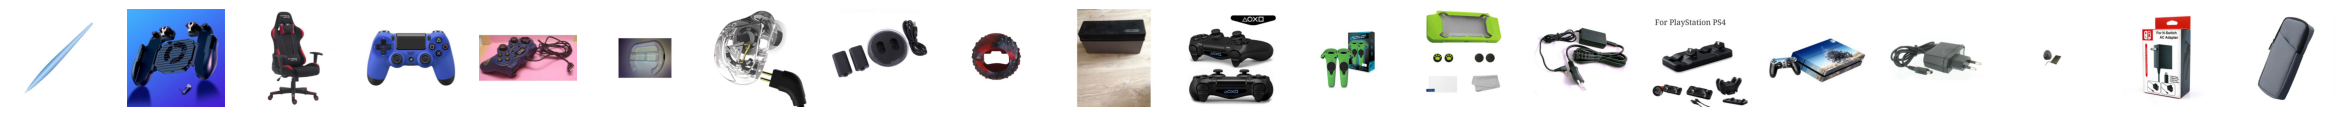

Before cleaning
Top 5 features when designation ['console' 'jeu' 'manette' 'nintendo' 'ps4']
Top 5 features when designation+description ['39' 'br' 'console' 'jeu' 'nintendo']
After cleaning
Top 5 features when designation ['console' 'jeu' 'manette' 'nintendo' 'ps']
Top 5 features when designation+description ['charge' 'console' 'jeu' 'nintendo' 'ps']
-----------------------------------------------------------------------
First 20 entries for type 60


designation  \
40    Mini Console De Jeux Double Joueurs 8 Bits Con...   
180   Nouvelle Console De Jeu Vidéo Portable Rétro 1...   
270   5.1 Pouces Hd Écran Double Joystick Lecteur De...   
299   Lecteur Nostalgique Mini Lecteurs De Jeux Vidé...   
375   4.3 ''multi-Fonction Portable Jeu Console De J...   
530   Double Joystick 5.1 Pouces X7 Plus Joueurs De ...   
694   Mini Console De Jeu Tv 8 Bits Console De Jeu V...   
970                            New Nintendo 3ds Blanche   
1138  Powkiddy Rétro Portable Mini Console De Jeu De...   
1178  Mini Console De Jeu Vidéo Av Jeu 8 Bits Constr...   
1393  X12 5.1 Pouces Jeu De Poche Consoles De Jeu Vi...   
1400  Coolbaby Rs-88 Famille Poche Console De Jeu Ré...   
1484  Nouveau Rétro Fc Console De Jeu Vidéo Rétro Je...   
1682  Sega Megadrive Portable Edition Mortal Kombat ...   
1696  16 Gb Rs-97 Rétro Console De Jeu Portable Mini...   
1848                                   Ps3 Rouge 500 Go   
2050               Xbox One S 1 To Shadow Of War Bundle   
2120  2 Pièces Coolbaby Rs-6 Un Pro Mini Vidéo Lecte...   
2239  2019 Livraison Directe Rétro Mini Tv Vidéo Jeu...   
2250       Nintendo Gamecube - Console De Jeux - Violet   

                                            description  prdtypecode  
40    Nom de la marque:NoEnName_Null<br />Affichage ...           60  
180   Affichage de couleur:Oui<br />Paquet:Oui<br />...           60  
270   Numéro du modèle:model 310<br />Taille de l&#3...           60  
299   Affichage de couleur:Oui<br />Paquet:Oui<br />...           60  
375   Affichage de couleur:Oui<br />Nom de la marque...           60  
530   Nom de la marque:OWLLON<br />Affichage de coul...           60  
694   Affichage de couleur:Oui<br />Paquet:Oui<br />...           60  
970                                                 NaN           60  
1138  Nom de la marque:MOCUTE<br />Affichage de coul...           60  
1178  Affichage de couleur:Pas de<br />Numéro du mod...           60  
1393  Nom de la marque:ALLOYSEED<br />Affichage de c...           60  
1400  Numéro du modèle:V3<br />Affichage de couleur:...           60  
1484  Nom de la marque:DZT1968<br />Numéro du modèle...           60  
1682  SEGA MEGA DRIVE PORTABLE BLANCHE AVEC NOTICE E...           60  
1696  Affichage de couleur:Oui<br />Paquet:Oui<br />...           60  
1848                                                NaN           60  
2050  <p>Allez derrière les lignes ennemies pour for...           60  
2120  Nom de la marque:JRGK<br />Affichage de couleu...           60  
2239  Nom de la marque:NoEnName_Null<br />Communicat...           60  
2250                                                NaN           60

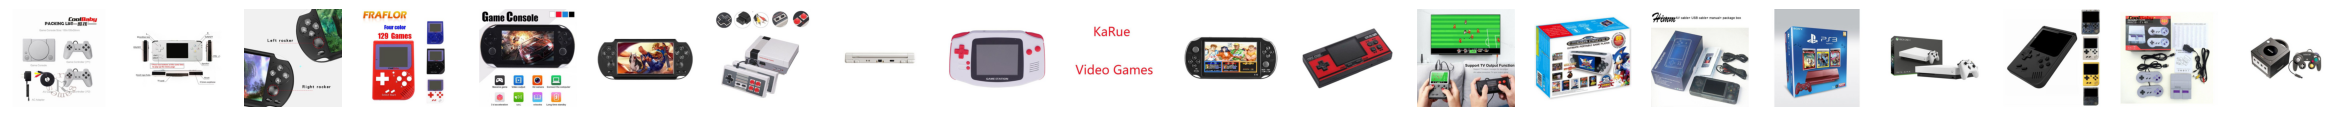

Before cleaning
Top 5 features when designation ['console' 'jeu' 'jeux' 'portable' 'vidéo']
Top 5 features when designation+description ['br' 'console' 'couleur' 'jeu' 'oui']
After cleaning
Top 5 features when designation ['console' 'jeu' 'jeux' 'portable' 'vidéo']
Top 5 features when designation+description ['console' 'jeu' 'jeux' 'marque' 'écran']
-----------------------------------------------------------------------
First 20 entries for type 1140


designation  \
18   Power Rangers Rouge Force Mystic Figurine Tran...   
23                           Véhicule Star Wars A-Ast5   
66                              Magnet Europe Paris 44   
72            Lampe Star Wars - Lampe Neon Sabre Laser   
98   It - Bobble Head Pop N° 539 - Beverly With Key...   
110  Figurine Zhu Zhu Pets - Zhu Zhu Pet Dans Son P...   
126   Chopper Dragon Ball Kai X One Piece Noël Edition   
160  Dragon Ball Soul Of Hyper Figuration Figurine ...   
196  Star Wars Episode Vii Salière Et Poivrière Bb-...   
276                      Porte Clefs - Ville D'avignon   
292  Figurine Champi Toad Super Mario Nintendo / Bl...   
304          Figurine Lucky Luke Dargaud Avec Pistoley   
347  Dragon Ball Z Ichiban Kuji Songoku Super Instinct   
362                              Doctor Who Mug Cosmos   
364                       Nendoroid More - Clip (Mint)   
370  Twilight Hésitation - Porte-Clés Métal Team Ed...   
390                              Gonzo The Muppet Show   
396    Les Schtroumpfs - Schtroumpf  Toothbrush  20064   
408  Figurine Papillon Rose Assis Avec Un Ballon - 5cm   
409  300-580 The Princess Shirahoshi One Piece 300 ...   

                                           description  prdtypecode  
18                                                 NaN         1140  
23     véhicule vintage de la saga star wars le A-AST5         1140  
66                                                 NaN         1140  
72   Lampe néon taille env. 22 x 28 cm avec base d¿...         1140  
98                                                 NaN         1140  
110                                                NaN         1140  
126  Edition RARE de CHOPPER en père Noël par BANPR...         1140  
160            Figurine d&#39;environ 5 cm de hauteur.         1140  
196  Salière et poivrière en céramique haute qualit...         1140  
276                                                NaN         1140  
292                                                NaN         1140  
304  figurine 7 cmtres rareLucky luke et son pistol...         1140  
347                                                NaN         1140  
362  Mug (grande tasse) en céramique au décor impri...         1140  
364                                                NaN         1140  
370  Porte-cl&eacute;s en m&eacute;tal haute qualit...         1140  
390                                                NaN         1140  
396                                                NaN         1140  
408                                                NaN         1140  
409                                                NaN         1140

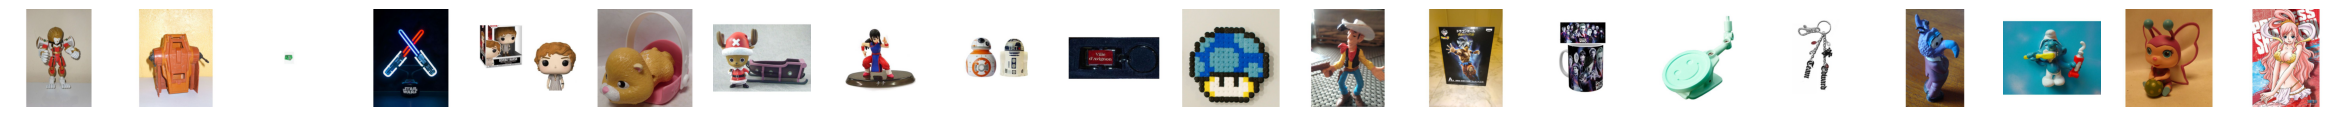

Before cleaning
Top 5 features when designation ['cm' 'figurine' 'pop' 'star' 'wars']
Top 5 features when designation+description ['br' 'cm' 'figurine' 'pop' 'taille']
After cleaning
Top 5 features when designation ['figurine' 'funko' 'pop' 'star' 'wars']
Top 5 features when designation+description ['figurine' 'pop' 'pvc' 'star' 'wars']
-----------------------------------------------------------------------
First 20 entries for type 1160


designation description  \
29   Dragon Ball Super - Bt3-070 - C-13 Les Prémiss...         NaN   
48            Dragon Ball Z - Serie 3 - 13 - Francaise         NaN   
109  N° 98 Roberto Pereyra  - Juventus - Adrenalyn ...         NaN   
115  Drakôn À Écailles De Chrome - Rare - Sombracie...         NaN   
155  Scott Mitchell - Cincinnati Bengals - 2001 Upp...         NaN   
179                       Tofu Malefique 29/162 Amakna         NaN   
225       Stass Allie 85 - Star Wars Force Attax 2012          NaN   
228                    Dragon Ball Power Level Z N°598         NaN   
240      Pokemon - Tentacool Createur De Legende 66/92       50PV.   
288  Yacine Brahimi 595 - Algérie - Stickers Fifa W...         NaN   
310  Carte Pokemon - Pandespiégle - Pv 60 - 71/122 ...         NaN   
428      Montagne Des Sept Tonnerres Édition Or Ge 535         NaN   
443                  Enjôleur Balshanique - Odyssée Vf         NaN   
447         Carte Yu-Gi-Oh! Oracle Du Héraut //Commune         NaN   
568  Archétype De L'imagination - Mtg - Commander 2...         NaN   
586  N°111 - Carte Match Attax Champions League 201...         NaN   
591  Wakfu Tcg - Ceinture Du Bandit - 137/162 - Astrub         NaN   
644             Esprit Des Nuages - Magic - Forteresse         NaN   
646                 Possession Psychique - Discorde Vf         NaN   
667  Territoire Xyz (Xyz Territory) - Yu-Gi-Oh! - P...         NaN   

     prdtypecode  
29          1160  
48          1160  
109         1160  
115         1160  
155         1160  
179         1160  
225         1160  
228         1160  
240         1160  
288         1160  
310         1160  
428         1160  
443         1160  
447         1160  
568         1160  
586         1160  
591         1160  
644         1160  
646         1160  
667         1160

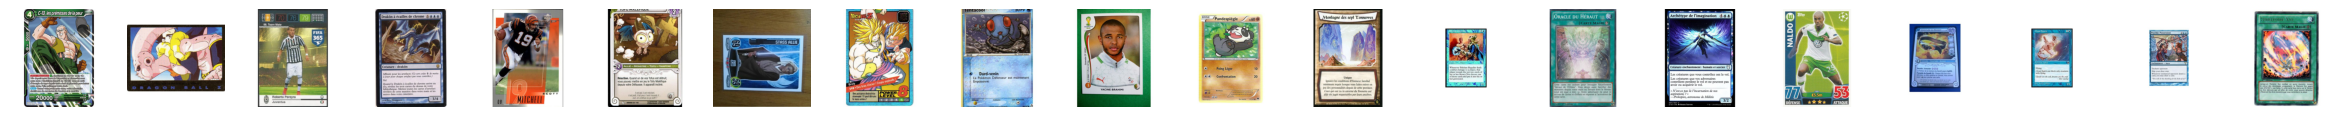

Before cleaning
Top 5 features when designation ['carte' 'gi' 'magic' 'oh' 'yu']
Top 5 features when designation+description ['carte' 'gi' 'magic' 'oh' 'yu']
After cleaning
Top 5 features when designation ['carte' 'fr' 'gi' 'oh' 'yu']
Top 5 features when designation+description ['carte' 'fr' 'gi' 'oh' 'yu']
-----------------------------------------------------------------------
First 20 entries for type 1180


designation  \
22    Le Seigneur Des Anneaux Figurine En Plomb À Pe...   
41                   Présentoir À Biscuits Et Chocolats   
106   Comtes Vampires Lahmiane À Pied Et Montée Lahm...   
154    Mournblade - Ecran Et Cartes Des Jeunes Royaumes   
524   Warhammer 40000 ( 40k ) - Exo Armure Xv88 Broa...   
666                  Greyhawk Ad&d The Adventure Begins   
721                              Rage Across The Amazon   
747   Masque Halloween Masques Led Glow Light Up Mas...   
764   Vert Intérieur P010 Gamme Air - Pot De 17ml - ...   
999                         Red Steel - Savage Baronies   
1032  Parlainth: The Forgotten City - Earthdawn Camp...   
1139  Chariot À Tirer Et À Basculer « Nature » Non M...   
1150  Gris Us Moderne P047 Gamme Air - Pot De 17ml -...   
1219  Figurine Orc - Archer Orc En Plastique - Pour ...   
1309                        Légendes Des Terres Brûlées   
1323               Munchkin Cthulhu 4 : Oh My Grottes !   
1492  Figurine Guerrier - Archer En Cotte De Maille ...   
1520  Heroclix- Alex Wilder#031 (Extension Marvel Se...   
1643                    Train De Lettres "Wagon" Coloré   
1661    Warhammer Aos &amp; 40k - Portepestes De Nurgle   

                                            description  prdtypecode  
22                                                  NaN         1180  
41                                                  NaN         1180  
106                                                 NaN         1180  
154                                                 NaN         1180  
524   Ce kit contient 91 composants en plastique ain...         1180  
666                                                 NaN         1180  
721                                                 NaN         1180  
747   Masque Halloween LED Masques Glow Masque Effra...         1180  
764                                                 NaN         1180  
999   <br />Daring swashbucklers.<br />Stout mercena...         1180  
1032                                                NaN         1180  
1139                                                NaN         1180  
1150                                                NaN         1180  
1219                                                NaN         1180  
1309                                                NaN         1180  
1323  A propos : Munchkin Cthulhu vous a déjà rendu ...         1180  
1492                                                NaN         1180  
1520                                                NaN         1180  
1643                                                NaN         1180  
1661  Les portepestes forment les rangs des làgions ...         1180

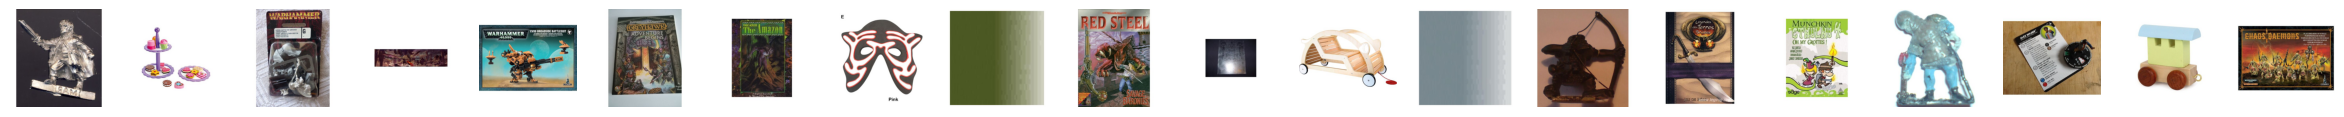

Before cleaning
Top 5 features when designation ['figurine' 'heroclix' 'masque' 'prince' 'warhammer']
Top 5 features when designation+description ['39' 'br' 'li' 'masque' 'warhammer']
After cleaning
Top 5 features when designation ['figurine' 'heroclix' 'masque' 'prince' 'warhaer']
Top 5 features when designation+description ['figurine' 'halloween' 'jeu' 'masque' 'warhaer']
-----------------------------------------------------------------------
First 20 entries for type 1280


designation  \
3    Peluche Donald - Europe - Disneyland 2000 (Mar...   
8            Puzzle Scooby-Doo Avec Poster 2x35 Pieces   
21                      Glitter Beach Barbie By Barbie   
26   Modèle De Voiture 4pcs Alliage Métallique 1.9i...   
49   100pcs Premium Bâtons Bracelets Neon Light Glo...   
55   Moakoada®Abs Congélateur Teether Sensorielle J...   
60   7pcs Mobilier De Poupées Pot De Fleur En Plast...   
88               Hello Kitty Ugly Doll Ox - 7 In Plush   
93   Lego® -Le Manège Sous-Marin Friends Jeux De Co...   
128                  Toyota Hiace Blue Impulse (White)   
136                                 Peluche Tic Ou Tac   
147  Pull-Over Top À Manches Longues Coton Imprimé ...   
151  Caméra Runcam Eagle 2 Pro 800tvl 21 Mm Cmos Fp...   
172  Fruit De Noix De Coco Boue Mélange Nuage Slime...   
202                      Amanda Family Amandas Kitchen   
209  Diy Maison De Noël Miniature Assemblez Led Dol...   
214  Manual Transformation Robot Toys Electronic Wa...   
215               Doudou Lapin Gipsy - Marron Et Blanc   
280  Strorage Sac Étanche Portable Portement Portab...   
327  Tiger & Bunny Sky High S.H. Figuarts Action Fi...   

                                           description  prdtypecode  
3                                                  NaN         1280  
8                                                  NaN         1280  
21     Original Barbie Doll. Contains glitter lotion..         1280  
26   4pcs alliage métallique 1.9in jante de roue po...         1280  
49   100PCS premium Bâtons Bracelets Neon Light Par...         1280  
55   ABS congélateur Teether sensorielle Jouet pour...         1280  
60   <p><b>La description:</b></p><br /><p> Belle c...         1280  
88   p7 inch plush features Hello Kitty dressed as ...         1280  
93                                                 NaN         1280  
128                                                NaN         1280  
136                                                NaN         1280  
147  <p><b>La description:</b></p><br /><p> 100% ne...         1280  
151  1 x caméra 1 x support en aluminium 1 x jeu de...         1280  
172  Fruit de noix de coco boue Mélange Nuage Slime...         1280  
202  pEquipment and furniture for playing in the ki...         1280  
209  Maison Bricolage miniature Meubles LED Maison ...         1280  
214  ManualTransformation Robot Toys Electronic Wat...         1280  
215                                                NaN         1280  
280  Strorage Sac étanche Portable Carrying Portabl...         1280  
327                                                NaN         1280

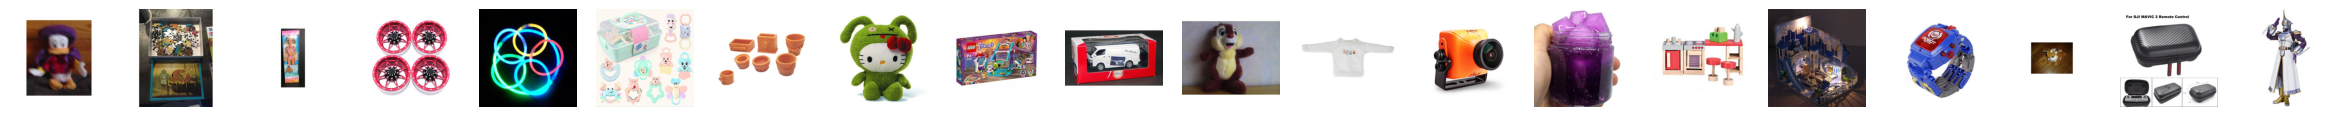

Before cleaning
Top 5 features when designation ['enfants' 'jouet' 'jouets' 'peluche' 'toy']
Top 5 features when designation+description ['39' 'br' 'enfants' 'jouet' 'taille']
After cleaning
Top 5 features when designation ['enfants' 'jouet' 'jouets' 'peluche' 'toy']
Top 5 features when designation+description ['bébé' 'enfants' 'haute' 'jouet' 'jouets']
-----------------------------------------------------------------------
First 20 entries for type 1281


designation  \
12   Peaceable Kingdom Wheres Bear? The Hide And Fi...   
37   Nouveau 01h20 Échelle Alloy Mini Pull Back Voi...   
43   Non Toxique Effacer Slime Coul Beau Mélange Nu...   
52                                 Le Mot Le Plus Long   
135  Dinosaur Bubble Light Up Bulles Ventilat Avec ...   
229  Lost In Rlyeh Card Game (Call Of Cthulhu) In T...   
279                       Unbalanced M2 (Japan Import)   
306  100 Ml Coul Belle Mélange Nuage Slime Putty Pa...   
330                                  Hay Is For Horses   
356  Fun Bricolage Doodling Dessin Magie Peinture S...   
367                    Marvel Heroes Album De 32 Pages   
400          Shardwrack Spines 64-04 - Warhammer 40000   
404  Harrows - Jeu De 3 Fléchettes - Embout Acier -...   
441  Jouets Pour Enfants Jigsaw En Bois Pour L'éduc...   
459  2pcs Bébé Enfants Jouets De Bain Piscine Wash ...   
501  Jeu De 54 Cartes Publicitaires - Mabec Motocul...   
537  Les Enfants En Bois 16 Pièces De Puzzle Jouets...   
563                      Les Ateliers De La Maternelle   
661  Nouveau Coton Boue Puff Slime Putty Parfumée S...   
662  Tirez L'ancien Tarot De Marseille Automatiquem...   

                                           description  prdtypecode  
12   pCan my 2-year-old play a game? Yes Each game ...         1281  
37   NOUVEAU 01h20 échelle Alloy Mini Pull Back Voi...         1281  
43   Non toxique Effacer Slime Couleur Beau mélange...         1281  
52                                                 NaN         1281  
135  Dinosaur Bubble Light Up Bulles ventilateur av...         1281  
229  pRlyeh is a horrible ancient city risen from t...         1281  
279                                                NaN         1281  
306  100 ml Grain de Riz Couleur Mud Beau mélange N...         1281  
330  Hay is for Horses is a fast paced card game th...         1281  
356  Jouets Scratch Art Magic Paper Peinture Dessin...         1281  
367  MARVEL HERoeS Album de 32 pages<br />PANINI - ...         1281  
400                                                NaN         1281  
404  Jeu de fléchettes en laiton pour cibles tradit...         1281  
441  Les enfants en bois Puzzle jouets pour l&#39;é...         1281  
459  2pcs bébé Enfants Jouets de bain Piscine Wash ...         1281  
501                                                NaN         1281  
537  Les enfants en bois 16 Piece Puzzle jouets pou...         1281  
563                                                NaN         1281  
661  Nouveau coton boue Puff Slime Putty parfumée S...         1281  
662                   Système électronique de voyance.         1281

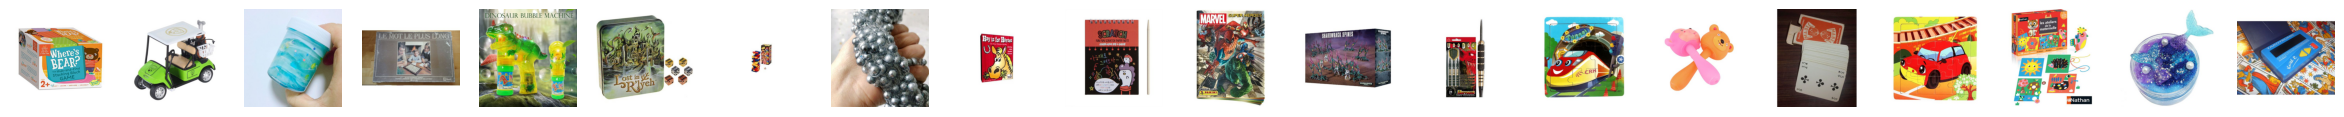

Before cleaning
Top 5 features when designation ['enfants' 'game' 'jeu' 'jouets' 'toy']
Top 5 features when designation+description ['39' 'br' 'enfants' 'jeu' 'jouets']
After cleaning
Top 5 features when designation ['enfants' 'game' 'jeu' 'jouets' 'toy']
Top 5 features when designation+description ['bébé' 'enfants' 'jeu' 'jouet' 'jouets']
-----------------------------------------------------------------------
First 20 entries for type 1300


designation  \
24   Mini Wifi 720p Caméra Drone Rc Quadcopter 24 G...   
59   Moakoada®Body Wrap Peau Autocollant Decal Pour...   
63   2.4g 6-Axis Wifi Fpv Drone 0.3mp Caméra Terre-...   
81   Maquette D'avion Protective Silicone Cover Cas...   
104  Noch - 14222 - Modélisme Ferroviaire - Passere...   
105  Maquette D'avion Syma X5uw 6 Axis Gyro Wifi Fp...   
134  Subaru Impreza Wrx Police 20003 - Norev 1/43 8...   
140  Sac Portable Étanche Sacoche De Transport 2 Pi...   
146  2.4g 4ch Altitude Attente Rc Quadcopter Pocket...   
153        Maquette En Bois  - Scottish Maid-Artesania   
181  Poi_Stockage Portable Étanche Sac De Transport...   
199  Trx-4 82056-4 Boîte D'onde Châssis Cobweb Stru...   
219  Spark - 1/43 - Citroen C3 Wrc - Allemagne 2017...   
227               Solido Pompier Land Rover 109-Solido   
235  Syma X5 X5c X5c-1 Quadcopter Pièces De Rechang...   
237  Rc Pull Starter Hex 12mm Pour 1/8 1/10 Nitro S...   
267              Micro Voiture De Course Galoob-Galoob   
274  Rc Car Set Model Car 3d Puzzle Kid Toy Stem Ed...   
277         Figurine En Résine 120 Mm Swat 3 Mm128-Sol   
293  Maquette D'avion Pro Cnc Gimbal Arm Brackect Y...   

                                           description  prdtypecode  
24   Mini Wifi 720P Caméra Drone RC Quadcopter 24 G...         1300  
59   Body Wrap peau autocollant Decal Pour DJI Phan...         1300  
63                                                 NaN         1300  
81   Silicone CoverCase With Handheld Lanyard For D...         1300  
104                                                NaN         1300  
105  SYMAappareils de commande à distance simaX5UWL...         1300  
134                    VOITURE MINIATURE échelle 1/43.         1300  
140  Sac portable étanche Housse de transport 2 pil...         1300  
146  2.4G 4CH Altitude attente RC Quadcopter Pocket...         1300  
153  Maquette en bois - Scottish Maid - Maquette en...         1300  
181  Stockage étanche Sac transport rigide Valise P...         1300  
199  TRX-4 82056-4 &amp; nbsp; Vague Boîte châssis ...         1300  
219  <strong>- Fabricant :</strong> SPARK <br /><st...         1300  
227                                                NaN         1300  
235  Syma X5 x5C x5C-1 quadcopter Pièces de rechang...         1300  
237  RC Pull Starter Hex 12mm For 1/8 1/10 Nitro SH...         1300  
267                                                NaN         1300  
274  RC Car Set Model Car 3D Puzzle Kid Toy Toy STE...         1300  
277                                                NaN         1300  
293  MX0045Il applique àDJIDajiang Assistant3pièces...         1300

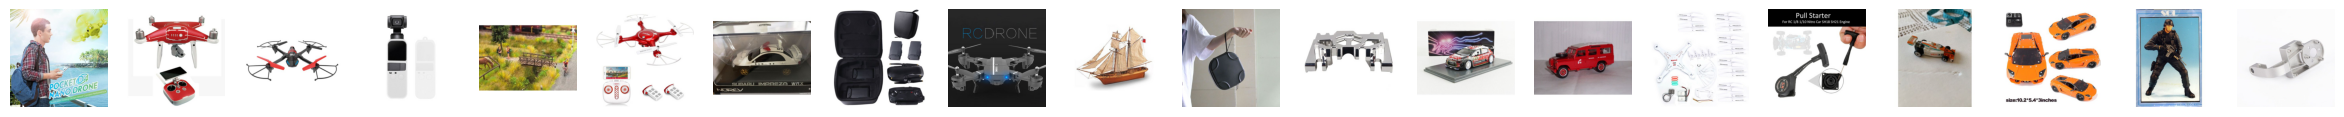

Before cleaning
Top 5 features when designation ['dji' 'drone' 'générique' 'quadcopter' 'rc']
Top 5 features when designation+description ['39' 'batterie' 'br' 'drone' 'rc']
After cleaning
Top 5 features when designation ['dji' 'drone' 'générique' 'quadcopter' 'rc']
Top 5 features when designation+description ['batterie' 'dji' 'drone' 'quadcopter' 'rc']
-----------------------------------------------------------------------
First 20 entries for type 1301


designation  \
257   Enfants bébé tout-petits garçons Bébés filles ...   
289   9 Balles de Baby Foot Bonzini Balles en Liège ...   
945   Nouveau-né Bébé Garçons Filles Cartoon animaux...   
989   Cavalier 3 PCS / Set 23g En Aluminium Arbres E...   
1333           Ailette Fléchette Marathon Urban-Harrows   
1370  MagiDeal 2pcs Accessoire De Table De Baby-Foot...   
1394  Enfants bébé tout-petits garçons Bébés filles ...   
1560  1 paires Bébés garçons filles tricot coton cha...   
1677               Table De Air Hockey Avec Accessoires   
1805  Nouveau-né Bébés filles bowknot dentelle coton...   
1846  Bébé fille de garçon chaussettes coton enfants...   
1910  Lot de 10 balles blanches en plastique babyfoo...   
2088  Cartoon bébé nouveau-né Filles Garçons Bottes ...   
2193  MagiDeal Base De Football De Siège De Basket-b...   
2238         Housse Peradon pour queue Monobloc-Peradon   
2465           Ailettes Prime Rouge (3) Harrows-Harrows   
2535  Nouveau-né bébé Cartoon bébé nouveau-né Filles...   
2579  6pcs recharge fléchettes 9.5cm Blaster Bullet ...   
2801  Anti-dérapants bébé Princesse Chaussettes Chau...   
2848  Nouveau-né Bébé Garçons Filles Cute Cartoon ch...   

                                            description  prdtypecode  
257   Enfants bébé Tout-petit bébé Garçons Filles Ca...         1301  
289   Diamètre de 35mm. Balles de baby foot en liège...         1301  
945   Nouveau-nés garçons Bébés filles Cartoon anima...         1301  
989   Cavalier 3 PCS / Set 23g En Aluminium Arbres E...         1301  
1333  Ailette Marathon pour fléchette. La conception...         1301  
1370                                                NaN         1301  
1394  Enfants bébé Tout-petit bébé Garçons Filles Ca...         1301  
1560  1 paires Bébés garçons filles tricot coton cha...         1301  
1677  Dimension de la table: 183 x 92 x 81 cm<br />D...         1301  
1805  Nouveau-né bébé Filles bowknot dentelle coton ...         1301  
1846  Bébé garçon chaussettes fille coton enfants ch...         1301  
1910  La référence en matière de balle de babyfoot f...         1301  
2088  Cartoon bébé nouveau-né Filles Garçons Anti-Sl...         1301  
2193                                                NaN         1301  
2238  Longueur : 152 cm.  <br />Housse souple noire....         1301  
2465  Marque Harrows : l&#39;excellence de la fléche...         1301  
2535  Nouveau-né bébé Cartoon bébé nouveau-né Filles...         1301  
2579  Description:<br />Recharge de fléchettes en mo...         1301  
2801  Antiglisse bébé princesse Chaussettes du nouve...         1301  
2848  Nouveau-né Bébé Garçons Filles Cute Cartoon ch...         1301

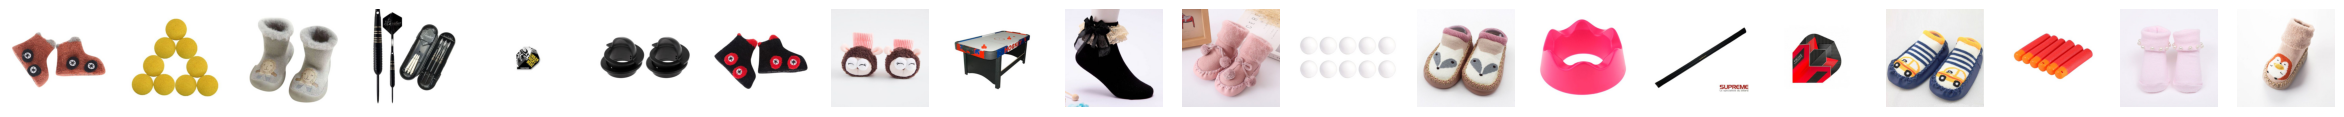

Before cleaning
Top 5 features when designation ['auucne' 'bébé' 'chaussettes' 'enfants' 'filles']
Top 5 features when designation+description ['39' 'br' 'bébé' 'chaussettes' 'taille']
After cleaning
Top 5 features when designation ['auucne' 'bébé' 'chaussettes' 'enfants' 'filles']
Top 5 features when designation+description ['bébé' 'chaussettes' 'filles' 'longueur' 'qualité']
-----------------------------------------------------------------------
First 20 entries for type 1302


designation  \
76   60ml Halloween Head Ghost Mélange Nuage Slime ...   
79   Squishies Adorable Pingouin Squeeze Rising Slo...   
114  Jouet Halloween Horror Grimace Night Terror Ma...   
120         Trampoline Berg Elite Inground Rouge 430cm   
125  1pc Leurres 9cm Plastique Hardbass Appâts 8 Co...   
185             Little Tikes Tricycle Perfect Fit Rose   
246      Gunther Parachute A Lancer - Modele Aléatoire   
269  Néoprène Sport Sweat Gilet Taille Débardeur Tr...   
294  Musique Électronique Pour Enfants Jouet De Pêc...   
295  Premium Doux Tissé Grille Avec Apple Sport Rep...   
371  Fraise Rouleau Parfumée Collection Charm Lente...   
419  1200lm Cob Led Magnétique Fin Travail D'inspec...   
453  Extérieur Hamac Anti-Moustique Hamac Portable ...   
548  Arebos Coussin De Protection Des Ressorts Pour...   
564  Kangui - Coussin De Protection Pour Trampoline...   
576  Kangui - Coussin De Protection Bleu Ø305cm Pou...   
579  Panda Spongieuse Poisson Parfumé Collection Le...   
585        Beach Toys La Reine Des Neiges - Kick Board   
617  Hamacs Extension Cordes Ceinture Solide Deux S...   
626  Silicone Gripper En Silicone De Remise En Form...   

                                           description  prdtypecode  
76   60ML Halloween Head Ghost Mélange Nuage Slime ...         1302  
79   Squishies adorable pingouin lente hausse Squee...         1302  
114  Halloween Pumpkin Ice Cream Slow Rising Collec...         1302  
120  Le BERG Elite InGround est le meilleur trampol...         1302  
125  1pc Leurres 9cm plastique Hardbass Appâts 8 co...         1302  
185  LITTLE TIKES Tricycle Perfect Fit Rose - Tricy...         1302  
246  GUNTHER Parachute a lancer - Modele aléatoire<...         1302  
269  Néoprène Sport Sweat Gilet taille Débardeur Tr...         1302  
294  <div>Caractéristiques:</div><div>. Fait de mat...         1302  
295  Premium doux tissé Grille avec Apple Sport Rep...         1302  
371  Fraise Rouleau parfumé Charme lent Rising Coll...         1302  
419  1200lm COB LED magnétique FIN travail Lumière ...         1302  
453  Caractéristiques:<br />Condition: 100% tout ne...         1302  
548  <strong><ul><li>Sécurité maximale grâce au dou...         1302  
564  <p>Avec le temps votre coussin s&#39;abîme par...         1302  
576  <p>Avec le temps votre coussin s&#39;abîme par...         1302  
579  Squishy poisson Panda Scented lente Collection...         1302  
585                            Kick Board Frozen 46 cm         1302  
617  Hamacs Extension Cordes ceinture solide Deux s...         1302  
626  Gripper Silicone Fitness type D anneau en caou...         1302

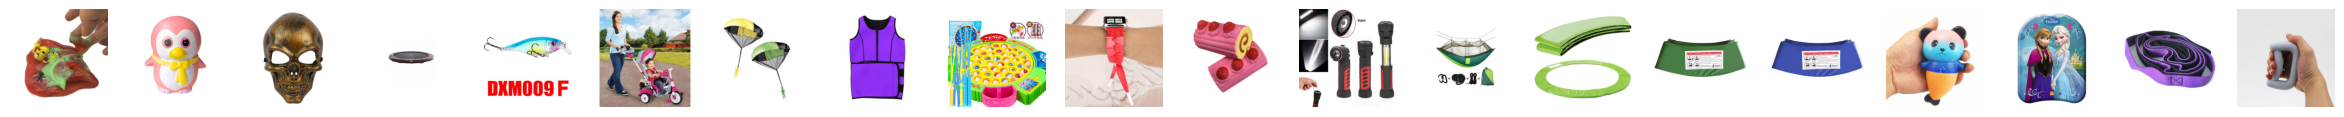

Before cleaning
Top 5 features when designation ['lampe' 'ligne' 'pêche' 'stream' 'stress']
Top 5 features when designation+description ['39' 'br' 'li' 'pêche' 'taille']
After cleaning
Top 5 features when designation ['lampe' 'led' 'pêche' 'stream' 'stress']
Top 5 features when designation+description ['coe' 'enfants' 'haute' 'pêche' 'stress']
-----------------------------------------------------------------------
First 20 entries for type 1320


designation  \
62   Largo 3 En 1 Poussette Combinée Parasol Siège ...   
124                       Wood Puzzle 3d Lion 7 Pièces   
138  Siège Auto Et Rehausseur Disney Avec Dossier G...   
143                       Coffre À Jouet En Osier Gris   
191                     Tigex Bavoir A Enfiler 6 Mois+   
230   Meme Georgette Purée De Pomme Abricot Bio - 360g   
245           Housse De Coussin D Allaitement Form-Fix   
290  Mode Féminine Caméra Comme Sac Bandoulière En ...   
314        Mes 1er Jouets - Chenille Articulée À Tirer   
321  Noeud Coloré Doux Bébé Coussin Tressé Coussin ...   
329  Bavoir Taille 1 Tendresse Lapin Tartine Et Cho...   
382  Zöllner Schlafsack Mit Applikation Sternchen B...   
383  Femmes Mode Chaîne Sac À Bandoulière Tissé Buc...   
394  Lot De 3 Petits Langes En Mousseline De Coton ...   
450  Bavoir Bébé Signe Astrologique Verseau Simple ...   
560     Sac À Dos San Francisco Noir / Or Rose - Beaba   
582  Hoppediz - L-Del - Écharpe Porte-Bébé En Sergé...   
587                Suspension Décoration Murale Merlin   
588  Protege Carnet De Sante Chat Blanc Marie Etoil...   
615  Lot De 2 Sucettes Dentition Et De Gencives Ros...   

                                           description  prdtypecode  
62   Largo Poussette 3 en 1 <br> Combinée combinée ...         1320  
124                                                NaN         1320  
138                                                NaN         1320  
143                                                NaN         1320  
191                                                NaN         1320  
230                  Purée de pomme abricot bio - 360g         1320  
245                                                NaN         1320  
290  Mode féminine Caméra simili-cuir sac à bandoul...         1320  
314                                                NaN         1320  
321  Noeud coloré doux bébé oreiller Tressé Pare-ch...         1320  
329  <div class="rakuten_rich_content" ><div> <h2>U...         1320  
382  Zöllner Schlafsack mit Applikation Sternchen b...         1320  
383  Femmes Mode Chaîne tissé Sac à bandoulière Sac...         1320  
394  <p>  <strong>Le musy</strong> <strong>un lange...         1320  
450                                                NaN         1320  
560  Découvrez ce joli sac à langer San Francisco à...         1320  
582  Les écharpes porte-bébés tissées sont justemen...         1320  
587  <div class="rakuten_rich_content" ><div> <h3>S...         1320  
588                                                NaN         1320  
615                                                NaN         1320

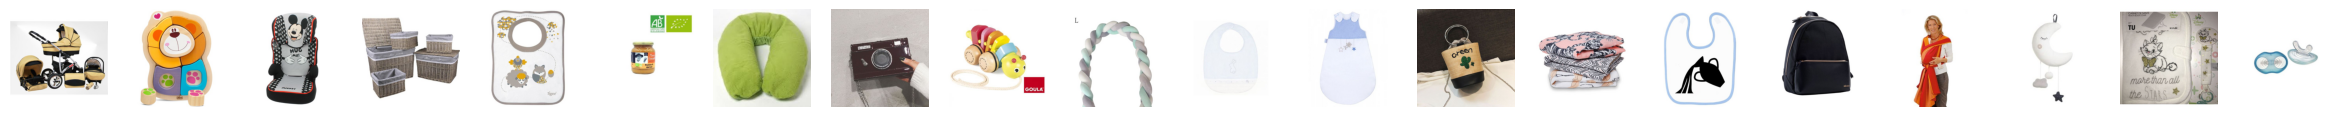

Before cleaning
Top 5 features when designation ['bavoir' 'bleu' 'bébé' 'cm' 'sac']
Top 5 features when designation+description ['39' 'br' 'bébé' 'cm' 'sac']
After cleaning
Top 5 features when designation ['bavoir' 'bleu' 'bt' 'bébé' 'sac']
Top 5 features when designation+description ['bébé' 'poussette' 'sac' 'style' 'sécurité']
-----------------------------------------------------------------------
First 20 entries for type 1560


designation  \
10             Eames Inspired Sxw Chair - Pink - Black   
11   Fauteuil Chesterfield Brenton 100% Cuir De Buf...   
14   Matelas Mémoire De Forme 180x200 X 20 Cm Très ...   
32   2 Cagettes De Rangement Happy Life - 40 X 30 C...   
78   Crochets Plafond Crochets Coupe À Vis Des Croc...   
85   Lot De 6 Chaises De Salle À Manger Style Indus...   
87   Sacs De Couverture De Bouteille De Bière Décor...   
95   Magasin Zhufuwme:English Alphabet Coussin Impr...   
119  Bas De Noël Chaussettes Père Noël Candy Bag Ca...   
132  3pcs Motif Saint Valentin Antiderapant Abattan...   
133  Bontempi Casa Table Avec Structure Anthracite ...   
158  Casa Padrino Baroque Dining Room With Armrests...   
170  1pcs Bbq Grill Mat Mat Pad En Fibre De Verre À...   
182  Table De Chevet Verona 3 Tiroirs Coloris Blanc...   
194  Sac Poubelle De Taille Mural Boîte De Rangemen...   
220  Plaque Mini Gâteau Renouvelable Plate-Forme Tu...   
223  Lit Enfant 120x200 Cm Avec 1 Tiroir Coloris Bl...   
251  Vidaxl Buffet Bois De Récupération Solide 160 ...   
263  Bouteille De Vin Ouvreur Étui En Cuir Sac En C...   
271  Easter Bunny Ears Bag Rabbit Gift Basket Shopp...   

                                           description  prdtypecode  
10   The timeless DSW seat can now be paired with m...         1560  
11   Canapé et fauteuil chesterfield en cuir antiqu...         1560  
14   MATELAS:<br />Â· Accueil : Ferme .<br />Â· Sou...         1560  
32   Organisez et rangez de manière scandinave votr...         1560  
78   Plafond Crochets Coupe à vis des crochets Plan...         1560  
85   <p>Lot de 6 chaises en métal robuste et intemp...         1560  
87   Bouteille de bière Couverture Sacs Décoration ...         1560  
95   English Alphabet Coussin Imprimer Coussin Fleu...         1560  
119  Bas de Noël Chaussettes Père Noël Candy Bag ca...         1560  
132  Motif du jour de 3PCS Valentine Antiderapant s...         1560  
133  Le table Artistico Bontempi Casa créée par une...         1560  
158  <p><span id="result_box" lang="en" tabindex="-...         1560  
170  1pcs BBQ Grill Mat Mat antiadhésives Pad en fi...         1560  
182  Le chevet VERONA apportera un plus de vivacité...         1560  
194  Accueil Sacs à ordures Creative Support de ran...         1560  
220  Plate Mini Cake Plate-forme ronde renouvelable...         1560  
223  Livraison sous 30 à 50 jours ouvrés (Hors Week...         1560  
251  <p>Ce buffet en bois de récupération solide ap...         1560  
263  Bouteille de vin ouvreur étui en cuir Sac en c...         1560  
271  Easter Bunny Ears Bag Rabbit Gift Basket Shopp...         1560

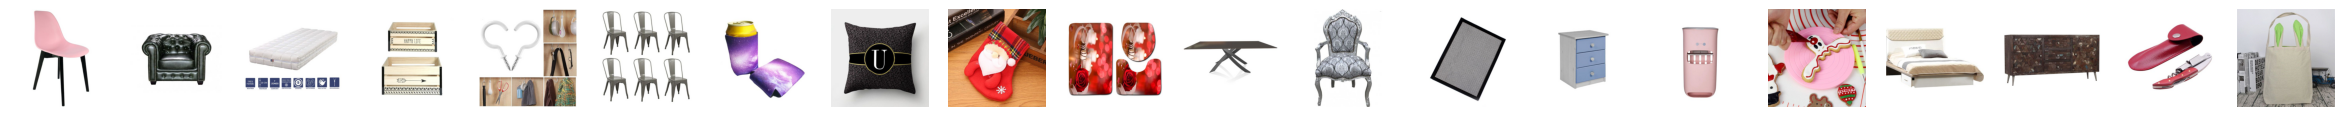

Before cleaning
Top 5 features when designation ['blanc' 'cm' 'cuisine' 'matelas' 'table']
Top 5 features when designation+description ['39' 'br' 'cm' 'li' 'strong']
After cleaning
Top 5 features when designation ['bois' 'chaise' 'cuisine' 'matelas' 'table']
Top 5 features when designation+description ['bois' 'haute' 'matelas' 'qualité' 'table']
-----------------------------------------------------------------------
First 20 entries for type 1920


designation  \
13                Paire De Voilages Imprimés Fantaisie   
38   4pcs Décor Coussin Indépendance Style Jeter Co...   
45   Rideau A Oeillets Plastique Polyester Uni Esse...   
92   Coussin En Peluche Canapé Taille Coussin Throw...   
103  Canapé Mignon Lit Pour Chat Accueil Décoration...   
157  32cm Emoji Smiley Emoticon Coussin Jaune Ronde...   
177  Nouveau Lin Coton Noël Oreiller Canapé Case Co...   
205  Trois Pièces Literie Tribute Coton Taie Modèle...   
226  2019 Nouveau Géométrique Linge Taie Canapé Lan...   
239  3d Imprimé Cat Coussin Peluche Simulation Cade...   
250  Motif Géométrique Irrégulière Coussin Coussin ...   
253  Décoration Du Foyer Coussin Graffi Style Throw...   
256  Oiseau Cotton Tree Linge Coussin Coussin Case ...   
261  Protège Matelas Absorbant Antonin Blanc 160x19...   
268  Décoration Du Foyer Coussin Fleur Vase Throw C...   
307  Trois Pièces De Mode 3d Literie D'impression N...   
309  Décoration Du Foyer Coussin Heureux Sunmer Tem...   
350  Impression Créative Accueil Tapisserie Tenture...   
368  Vintage Camera Taie Canapé Throw Taille Coussi...   
376  Cas Heureux Halloween 45cmx45cm Oreiller Autom...   

                                           description  prdtypecode  
13   Paire de voilages droits fantaisie qui mettra ...         1920  
38   4pcs Décor Coussin Independence Day Style de T...         1920  
45   rêt-à-poser ce rideau s'installe facilement et...         1920  
92                                                 NaN         1920  
103  Chien mignon Canapé-lit Décoration Pillow Fest...         1920  
157  32cm Emoji Smiley Emoticon Coussin rond jaune ...         1920  
177  Nouveau Lin Coton de Noël Taie d&#39;oreiller ...         1920  
205  Trois pièces Literie Tribute coton Taie motif ...         1920  
226  2019 Nouveau géométrique Linge Taie Canapé Lan...         1920  
239  3D Imprimé Cat Coussin peluche Simulation cade...         1920  
250  Motif géométrique irrégulière Coussin Taie d&#...         1920  
253  Décoration du foyer Coussin Graffi style Jeter...         1920  
256  Oiseau Cotton Tree Linen Pillow Coussin Case C...         1920  
261  <p>Molleton 220 gr/m2 - gratté-croisé sur les ...         1920  
268  Décoration du foyer Coussin Vase de fleurs Thr...         1920  
307  Trois pièces de mode 3d Literie d&#39;impressi...         1920  
309  Décoration du foyer Coussin heureux Sunmer tem...         1920  
350  Impression créative Accueil Tapisserie Tenture...         1920  
368  Vintage Camera Taie Canapé Throw Coussin taill...         1920  
376  Happy Halloween 45cmX45cm Pillow cas Automne h...         1920

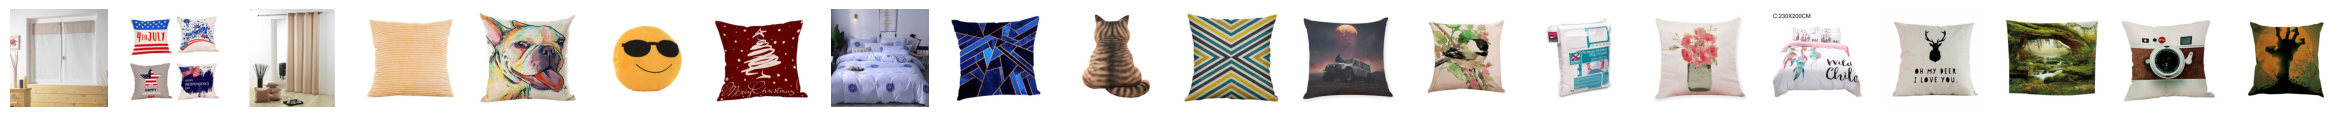

Before cleaning
Top 5 features when designation ['canapé' 'coussin' 'home' 'oreiller' 'taie']
Top 5 features when designation+description ['39' 'coussin' 'li' 'oreiller' 'taie']
After cleaning
Top 5 features when designation ['canapé' 'coussin' 'home' 'oreiller' 'taie']
Top 5 features when designation+description ['canapé' 'coussin' 'oreiller' 'plaît' 'taie']
-----------------------------------------------------------------------
First 20 entries for type 1940


designation  \
200   Lot De 5 Sachet Chewing Gum Pastèque Fini 100g...   
203   Tassimo Jacobs Espresso Rainforest Alliance Vé...   
406                   Dolce Gusto Espresso 16 Caps. 96g   
442   Twinings Gunpowder Thé Vert Menthe - Vrac/Boit...   
702   Haribo Gingembre-Citron Bonbons Bonbons Gélifi...   
724                 Haribo Oeufs Au Plat X 210  Bonbons   
1283                    Dulceplus Worms Acidulés Sucrés   
1307     Galettes De Riz Bio Au Chocolat Noir - 130.4 G   
1324    Miettes De Thon Blanc Germon À La Tomate 115 Gr   
1454                    Megabox Kinder Schoko-Bons Mini   
1468                Piment D'espelette Bio Aop Pot 50gr   
1656  Comte De La Seynie Rillettes Can. Foie Gras 2x...   
1819  Naturela  Café Instantané Lyophilisé - 100 % A...   
1892  Cannelle - Moulue - Vrac - Sac De Kraft De 170...   
1903   Mini Quatre-Quarts Pur Beurre Louis Le Goff 300g   
1978                     Friton Pur Porc Verrine 180 Gr   
2035          Pâte À Sucre Vert D'eau 250g Scrapcooking   
2178          Jelly Belly Island Punch (Punch Des Îles)   
2363                   Livre - Bd - Bernard De Claivaux   
2379  Pain Craquant Norvégien Graines De Courge Sigd...   

                                            description  prdtypecode  
200   Lot de 5 Sachet Chewing Gum Pastèque Fini 100g...         1940  
203   Tassimo Jacobs Espresso Rainforest Alliance Vé...         1940  
406   DOLCE GUSTO Espresso 16 Caps. 96g - 16 capsule...         1940  
442                                              <br />         1940  
702   Les bonbons Haribo gingembre-citron sont des b...         1940  
724   Confiserie g&eacute;lifi&eacute;e bicolore en ...         1940  
1283  Sachet de 100g<br>Assortiment de lucioles sucr...         1940  
1307  BJORG Galettes de riz bio au chocolat noir - 1...         1940  
1324                                                NaN         1940  
1454  Boîte de 2Kg<br>De petits bonbons de chocolat ...         1940  
1468  <strong>Piment d&#39;Espelette</strong> BIO et...         1940  
1656  COMTE DE LA SEYNIE Rillettes Can. Foie Gras 2x...         1940  
1819  NATURELA Café instantané lyophilisé - 100 % Ar...         1940  
1892  170 gr de votre cannelle moulue sont contenu d...         1940  
1903                                             <br />         1940  
1978  <h2>Friton pur porc Verrine 180 gr Maison Julh...         1940  
2035  Pâte à Sucre Vert d&#39;eau 250 g ScrapCooking...         1940  
2178  Sachet de 250g<br>Fabriqués aux USA en Califor...         1940  
2363  <strong>Bernard de Claivaux</strong><br /> <st...         1940  
2379  10 tranches<br /> Peut contenir des traces de ...         1940

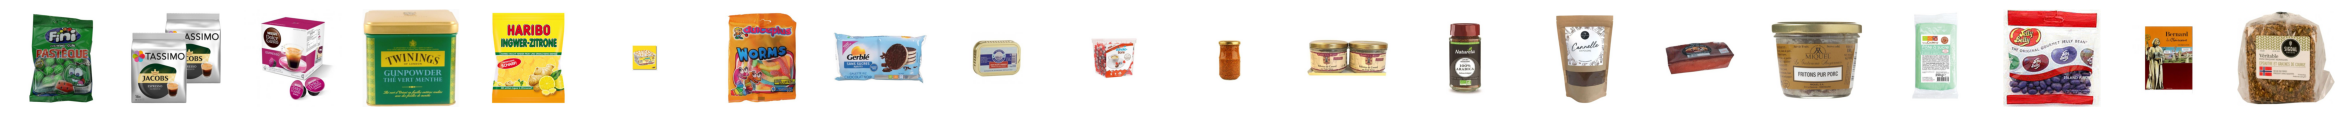

Before cleaning
Top 5 features when designation ['bio' 'café' 'capsules' 'chocolat' 'lot']
Top 5 features when designation+description ['39' 'bio' 'br' 'strong' 'sucre']
After cleaning
Top 5 features when designation ['bio' 'café' 'chocolat' 'gr' 'lot']
Top 5 features when designation+description ['bio' 'café' 'chocolat' 'produit' 'sucre']
-----------------------------------------------------------------------
First 20 entries for type 2060


designation  \
30   Lampe De Lecture Rechargeable Led Lampe De Bea...   
35   Decoration De Noel Christmas Snowman Kitchen T...   
36   30 Spots Encastrable Orientable Blanc Avec Gu1...   
67   Happy Halloween Sorcière Accueil Stickers Mura...   
77   Boite A Savons Metal Collection Moulin Rouge C...   
83   Vinyle Autocollant De Mur Stickers Home Decor ...   
99   4pcs Haut De Gamme De Vaisselle Couverts En Ac...   
121  Motif De Tapisserie De Mode Style Frais Tapiss...   
123  Rideau Voilage De Fenêtre Décoration Pour Cham...   
168        Figurine Porcelaine Chat Blanc Fleur Papier   
175  Les Nouvelles Vacances De Noël Etoiles Imprime...   
183  5d Broderie Peintures Strass Diamant Bricolage...   
187  Poignée En Bois De Bambou Creative Haut De Gam...   
190  Dekoarte 304 - Tableau Moderne Sur Toile Monté...   
212  Dies Découpe En Métal Stencil Pour Le Bricolag...   
213  75x140cm Absorbent Séchage En Microfibre Servi...   
216  Bonhomme De Neige De Noël 3.0m 16 Lumières Led...   
260  Moakoada®Cob + Led Rechargeable Torche Magnéti...   
311  Doauhao®Carte De Mariage Avec Boîte Coffrets C...   
323  12v 5m Smd 3528 300led Souple Et Étanche Chaud...   

                                           description  prdtypecode  
30   Nom de la marque:SYTH<br />Ampoules incluses:O...         2060  
35   Christmas Snowman Kitchen Table Chair Covers H...         2060  
36   <b>Lot de 30 Spots encastrable orientable BLAN...         2060  
67   Happy Halloween Sorcière Accueil amovible Wall...         2060  
77                                                 NaN         2060  
83   Vinyle autocollant de mur Stickers Home Decor ...         2060  
99   4pcs Set en acier inoxydable Haut de gamme Vai...         2060  
121  Tapestry &amp; nbsp Mode; Motif Style frais ta...         2060  
123  <p><b>La description:</b></p><br /><p> Rideau ...         2060  
168                                                NaN         2060  
175  Les nouvelles vacances de Noël Imprimer Étoile...         2060  
183  5D broderie Peintures strass diamant bricolage...         2060  
187  Poignée en bois de bambou créatif en acier ino...         2060  
190  ##Tableau de décoration moderne imprimé sur to...         2060  
212  Dies découpe en métal Stencil pour le bricolag...         2060  
213  75x140cm Absorbent séchage en microfibre Servi...         2060  
216  Noël Bonhomme de neige 3.0m 16 lumières LED Pa...         2060  
260  COB &#43; LED rechargeable magnétique Lampe to...         2060  
311  Carte de mariage boîte avec des boîtes de verr...         2060  
323  12V 5M SMD 3528 300LED souple et étanche chaud...         2060

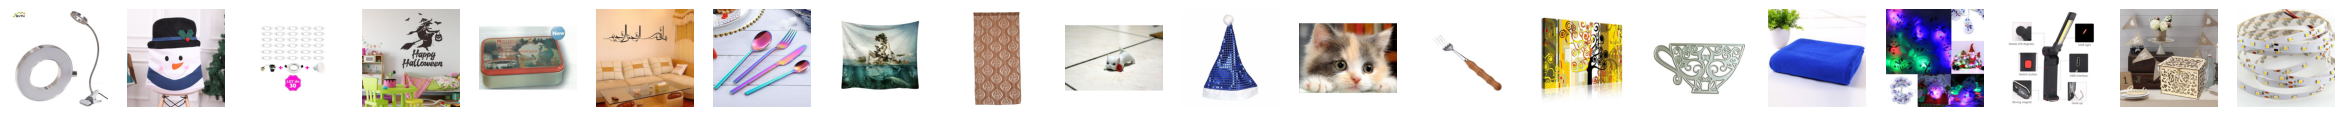

Before cleaning
Top 5 features when designation ['décor' 'décoration' 'lampe' 'led' 'noël']
Top 5 features when designation+description ['39' 'br' 'couleur' 'diamant' 'lumière']
After cleaning
Top 5 features when designation ['décor' 'décoration' 'lampe' 'led' 'noël']
Top 5 features when designation+description ['diamant' 'décoration' 'led' 'lumière' 'peinture']
-----------------------------------------------------------------------
First 20 entries for type 2220


designation  \
82                       Distributeur De Nourriture Tx2   
320   Chaîne Créative De Fission De Pied De Perroque...   
338   Mode Pet Keep Warm Amour Decorationcoat Chien ...   
354                  Matelas Pour Chiens Taille M Beige   
355             Ruban Multicolre Topline Plus Vert 40mm   
431      Décor Animaux Aquatic Jungle N°1 - Zolux - N°1   
488   Chien Animaux Santé Menstruelles Physiologique...   
543   Fun Chien Caoutchouc Mignon De Brown De Footba...   
924                          Coll Nyl Regl 25-45/65 Tur   
986   Xcsource Large Dog Playing Bed Mat Soft Warm P...   
1049         Kruuse - Gamelle Dogmaze Pour Chien - Bleu   
1136            Manteau Avallon Hot Dog 30cm Noir Jaune   
1187  Pet Self Cooling Gel Mat Cool Tapis Pour Chien...   
1217  Pet Gilet D'été Respirant Point Vague Modèle C...   
1260  Vêtements Pour Animaux Chien Noël Cerfs-Commun...   
1277  Sécurité Réglable Animaux Led Chien Clignotant...   
1290     Bea Flee-Flee Spray Répulsif Chien+Chat 200 Ml   
1294  Été Animal Veste Respirante Point Vague Confor...   
1487  Équilibre & Instinct - Croquettes Jeunes Chien...   
1558  New Pet Fashion Gilet Confortable Respirant Fl...   

                                            description  prdtypecode  
82    Pour chat et petit chien. Grâce au timer intég...         2220  
320   <p><b>La description:</b></p><br /><p> 100% ne...         2220  
338   Mode Pet Garder au chaud l&#39;amour Decoratio...         2220  
354   <p>Ce matelas pour chiens donnera à vos animau...         2220  
355   AKO TopLine Plus garantit une bonne conductivi...         2220  
431   Plongez dans l&#39;univers des Aquatic Jungle ...         2220  
488   Chien Animaux Santé menstruelles Physiologique...         2220  
543   Fun Pet Dog mignon en caoutchouc Brown de foot...         2220  
924                                                 NaN         2220  
986   <br />Features:<br /><br />Being with your lov...         2220  
1049  La gamelle Dogmaze est une solution parfaite p...         2220  
1136  Admirez la démarche enthousiaste de Gribouille...         2220  
1187  Pet Self Cooling Gel Mat cool tapis pour chien...         2220  
1217  Pet Gilet d&#39;été respirant point d&#39;onde...         2220  
1260  le chien de compagnie gray cerf pet pull à pet...         2220  
1277  Animaux de sécurité réglable chien LED clignot...         2220  
1290             BEA Flee-Flee spray répulsif chienchat         2220  
1294  Animaux été Veste respirante confortable impre...         2220  
1487  Les croquettes Équilibre et Instinct ont été c...         2220  
1558  New Pet Gilet confortable Mode respirant Fleur...         2220

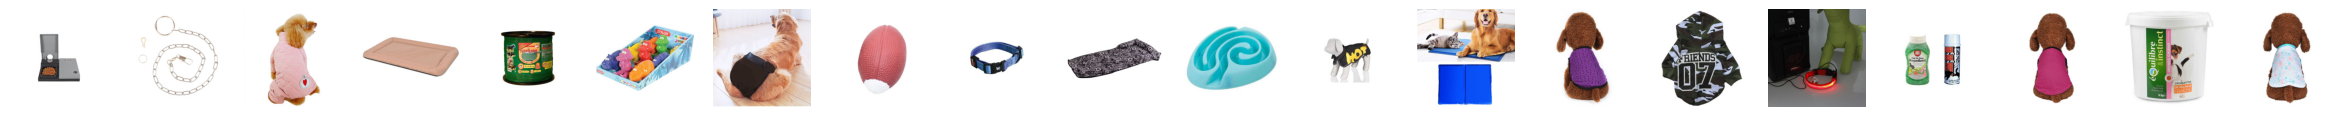

Before cleaning
Top 5 features when designation ['chat' 'chien' 'collier' 'pet' 'vêtements']
Top 5 features when designation+description ['39' 'br' 'chien' 'li' 'taille']
After cleaning
Top 5 features when designation ['chat' 'chien' 'collier' 'pet' 'vêtements']
Top 5 features when designation+description ['animal' 'animaux' 'chat' 'chien' 'pet']
-----------------------------------------------------------------------
First 20 entries for type 2280


designation  \
1    Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   
5    Afrique Contemporaine N° 212 Hiver 2004 - Doss...   
19   Monde Illustre (Le) N° 3083 Du 20/01/1917 - L'...   
28   Univers (L') N° 249 Du 12/09/1854 - France - P...   
44   Diagrammes N° 26 Du 01/04/1959 - Le Siecle Du ...   
68    La France Illustree N° 179 - Le Doux Far-Niente.   
75                                Réponse À Tout ! 282   
102  Video Tv Films N° 98 Du 01/09/1990 - Busqueda ...   
112                   Le Journal De Mickey N 126/ 1954   
127          Ultimate Spider-Man N° 30 : Hollywood (3)   
129  La Montagne 5e Annee N°12 - Souvenirs D'un Ski...   
137  Tv Magazine Le Parisien N° 21027 Du 06/04/2012...   
166                                Pour La Science 420   
169  Action Francaise (L') N° 287 Du 15/10/1923 - L...   
173                 Winnie   N° 198 : Spécial Monstres   
186       Programme  Officiel Festival De Cannes  2011   
222                        Cibles N° 312 Du 01/03/1996   
232  L'intrépide  N° 161 : Le Magazine Des Petitis ...   
233      Nintendo Le Magazine Officiel  N° 64 : Wiifit   
285  Top 50 127 N° 127 David Et Jonathan Eighth Won...   

                                           description  prdtypecode  
1                                                  NaN         2280  
5                                                  NaN         2280  
19                                                 NaN         2280  
28                                                 NaN         2280  
44                                                 NaN         2280  
68   Journal littéraire scientifique et religieux -...         2280  
75                                                 NaN         2280  
102                                                NaN         2280  
112                                                NaN         2280  
127                                                NaN         2280  
129                                                NaN         2280  
137                                                NaN         2280  
166                                                NaN         2280  
169                                                NaN         2280  
173                                                NaN         2280  
186                                                NaN         2280  
222  LE CZ 100 - LA CARABINE STOPSON ANTHIS - LE TA...         2280  
232                                                NaN         2280  
233                                                NaN         2280  
285   <p><strong>TOP 50 N° 127<br /></strong></p> <...         2280

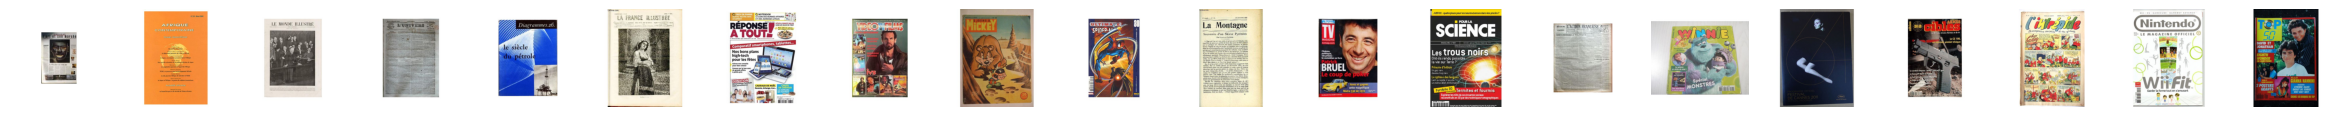

Before cleaning
Top 5 features when designation ['01' '10' '11' 'france' 'journal']
Top 5 features when designation+description ['01' '10' '11' 'france' 'journal']
After cleaning
Top 5 features when designation ['journal' 'magazine' 'monde' 'paris' 'revue']
Top 5 features when designation+description ['journal' 'magazine' 'monde' 'paris' 'revue']
-----------------------------------------------------------------------
First 20 entries for type 2403


designation description  \
16   Walter Scott Oeuvres Complètes Tomes 3456 10 E...         NaN   
51              One Piece Log 36 "Impel Down Partie 2"         NaN   
54                 Fate/Zero - Lot Mangas - Tome 1 À 5         NaN   
57                     Lot De 5 Livres Grans Peintres          NaN   
61   Lot Pf38 - 15 Marque-Pages (Illustrations Vint...         NaN   
69               Encyclopédie Universalis 32 Vol. 1990         NaN   
74   Lot 3 Livres Partitions - Hector L'apprenti Mu...         NaN   
96   Voici N°1231 Marion Cotillard & Son Fils Marce...         NaN   
113  Cahier De Notes Sur...La Prisonnière Du Désert...         NaN   
122                    Tennis Magazine - Lot De Revues         NaN   
156  Lot C29 De 25 Marque-Pages De Chats Sur Papier...         NaN   
161  Les Muses Encyclopédie Des Arts - Alpha Pour T...         NaN   
189  Journal Spirou 1° Trimestre 1986 (N° 2490 À 2502)         NaN   
192  Jardins D'aujourd'hui Revue Horticole Facicule...         NaN   
193                  Autres Lumières Barbara Robinson.         NaN   
236  Lot De 27 Magazines Canard Pc Canard Pc Hardwa...         NaN   
255  Les Pates  Extrait Du Livre " Les Pates Par Tu...         NaN   
283  Album Factice De Gravures De Mode Consacré Au ...         NaN   
286  Petite Section De Maternelle - Apprends-Moi Le...         NaN   
291                        Kaboom Intégrale Tome 1 À 3         NaN   

     prdtypecode  
16          2403  
51          2403  
54          2403  
57          2403  
61          2403  
69          2403  
74          2403  
96          2403  
113         2403  
122         2403  
156         2403  
161         2403  
189         2403  
192         2403  
193         2403  
236         2403  
255         2403  
283         2403  
286         2403  
291         2403

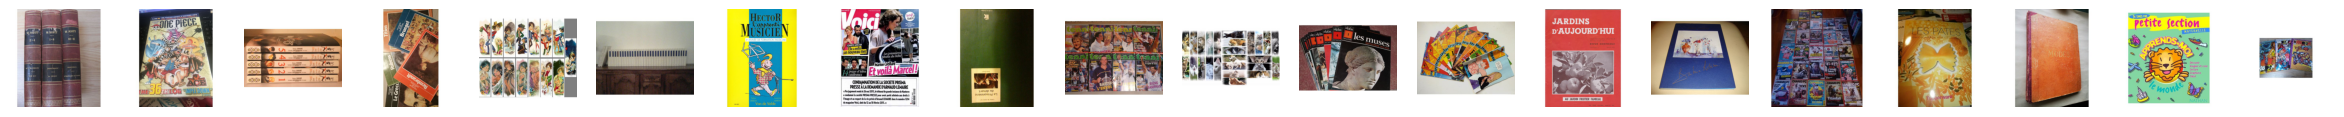

Before cleaning
Top 5 features when designation ['livres' 'lot' 'tome' 'tomes' 'volumes']
Top 5 features when designation+description ['livres' 'lot' 'tome' 'tomes' 'volumes']
After cleaning
Top 5 features when designation ['livres' 'lot' 'tome' 'tomes' 'volumes']
Top 5 features when designation+description ['livres' 'lot' 'tome' 'tomes' 'volumes']
-----------------------------------------------------------------------
First 20 entries for type 2462


designation description  \
25                   Dsi + Chargeur + Sacoche + 12 Jeux         NaN   
71              Xbox One 500 Giga Avc 3jeux Une Manette         NaN   
86    Xbox 360 Élite Noire 250go + 5 Jeux + Une Mane...         NaN   
238   Clementoni - 62580.2 - Jouet De Premier Age - ...         NaN   
324   Lot - Baldur&#39;S Gate - Dark Alliance Ii - 2...         NaN   
366   Lot De 7 Jeux Video Psp (God Of War Ghost Of S...         NaN   
389   Nintendo Game Boy Tm Transparente + Jeu Tetris...         NaN   
449       Army Men In Space Jeu Pc Big Box Grosse Boite         NaN   
578                                 Devil May Cry 4 Ps3         NaN   
589   Élément De Jeu - Jaquette De Remplacement - Fo...         NaN   
596   Vente D'une Console Ps2 Plus De 50 Jeux Divers...         NaN   
616         Lot De 2 Jeux De Football Sur Playsation 3          NaN   
625   Lot - Cars 2 - Sur Nintendo Ds + 1 Jeu Pc Neuf...         NaN   
680                    Xbox 360 Slim 9 Jeux 2 Manettes          NaN   
765                         Call Of Duty Edition Legacy         NaN   
827   Lot - Age Of Wonders - Shadow Magic - Sur Pc &...         NaN   
892   Lot Ensemble Collection Big Mutha Truckers - N...         NaN   
900    Boite D Origine De Rage Anarchy Edition Xbox 360         NaN   
1153  Xbox 360 120go + 2 Manettes + Adaptateur Wifi ...         NaN   
1182        Ps3 &#43;2 Manette &#43; 11 Jeux Bonne Etat         NaN   

      prdtypecode  
25           2462  
71           2462  
86           2462  
238          2462  
324          2462  
366          2462  
389          2462  
449          2462  
578          2462  
589          2462  
596          2462  
616          2462  
625          2462  
680          2462  
765          2462  
827          2462  
892          2462  
900          2462  
1153         2462  
1182         2462

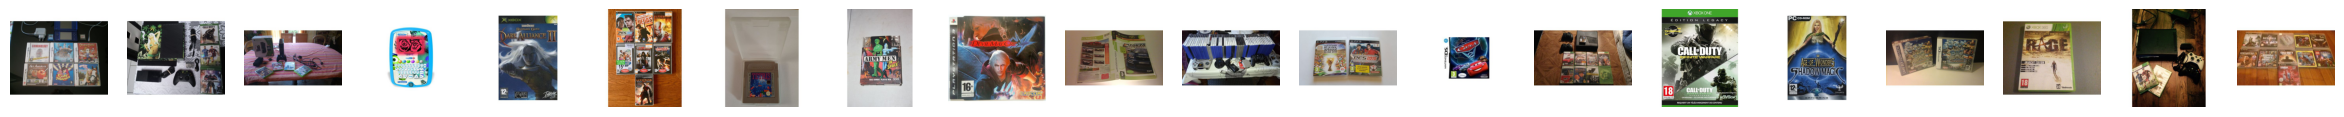

Before cleaning
Top 5 features when designation ['jeu' 'jeux' 'lot' 'pc' 'xbox']
Top 5 features when designation+description ['jeu' 'jeux' 'lot' 'pc' 'xbox']
After cleaning
Top 5 features when designation ['jeu' 'jeux' 'lot' 'ps' 'xbox']
Top 5 features when designation+description ['jeu' 'jeux' 'lot' 'ps' 'xbox']
-----------------------------------------------------------------------
First 20 entries for type 2522


designation  \
7    Conquérant Sept Cahier Couverture Polypro 240 ...   
15        Zenith Pince Agrafeuse 591 N°10 Coloris Noir   
17                 Mod Podge Dishwasher Safe Gloss 8oz   
27   Faber-Castell Lot De 3 Crayons De Couleur Poly...   
33   Lindner 2365-2115ce Coin Case Nera Xl With 3 T...   
42   Pilot Mr Stylo Plume Moyenne Design Crocodile ...   
89   Trodat Lot De 5 Cassettes Encreur De Rechange ...   
94   Herma Lot De 5 Protège-Cahiers Format A5 En Pp...   
97   Carnet De Notes Bloc-Notes Cahierles Yeux En F...   
149  Carnet De Notes Bloc-Notes Cahier La Cultureu ...   
159  Bloc Notes/Papier À Lettres De 15 Feuillets Li...   
198  Draeger Lot De 3 Stickers Mural Papillon Gold ...   
210  Lindner Dt209k-09-2014 Austria Sheetlets - Dt-...   
231  Leuchtturm Feuil. Compl. Sf France Blocks Cnep...   
243      Marque-Page Le Club - Osmose - Yann Queffélec   
254  Papier Kraft Merci Étiquettes Adhésives Vous R...   
278  480 Feuilles De Papier De Soie Bleu Turquoise ...   
284               Lindner 2358 Valise-Box En Aluminium   
297  Clairefontaine  Bloc Dessin À Grain Encollé A2...   
308  Exacompta Lot De 10 Class.S 4anx Iderama Pp A4...   

                                           description  prdtypecode  
7    CONQUERANT CLASSIQUE Cahier 240 x 320 mm seyès...         2522  
15   Pince agrafeuse 591 N°10. Capot en ABS. Dispos...         2522  
17                                                 NaN         2522  
27   FABER-CASTELL Crayon de couleur POLYCHROMOS ve...         2522  
33   Timeless elegance a clear design versatility f...         2522  
42   Couleur:Crocodile Noir/Bleu. Description du pr...         2522  
89   K7 encreur de rechange pour tampon 6/44045E Vi...         2522  
94                                                 NaN         2522  
97   Taille: En format A5 (144 cm x 21 cm) Caract¿¿...         2522  
149  Taille: En format A5 (144 cm x 21 cm) Caracter...         2522  
159                                                NaN         2522  
198  Sticker mural de 54 papillons dorés à disposer...         2522  
210             Sheet number: 93-99 Number of Pages: 7         2522  
231  avec pochettes de protection SF (100 % polysty...         2522  
243                                                NaN         2522  
254  Papier kraft Merci adhésif Étiquettes Thank Yo...         2522  
278  Brillant soyeux et naturel. Fibres vegetales r...         2522  
284  Valises-box en aluminium avec poignée de trans...         2522  
297            Bloc dessin à grain encollé A2 180g 30F         2522  
308                                                NaN         2522

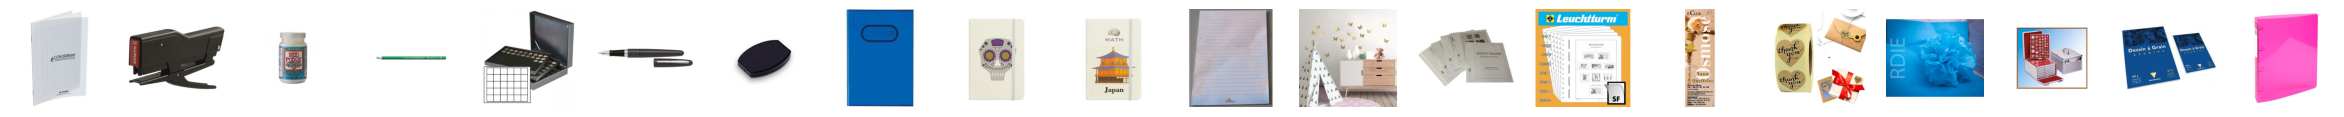

Before cleaning
Top 5 features when designation ['bloc' 'carnet' 'journal' 'lot' 'notes']
Top 5 features when designation+description ['39' 'br' 'cm' 'papier' 'strong']
After cleaning
Top 5 features when designation ['bloc' 'carnet' 'journal' 'lot' 'notes']
Top 5 features when designation+description ['format' 'haute' 'notes' 'pages' 'papier']
-----------------------------------------------------------------------
First 20 entries for type 2582


designation  \
9    Tente Pliante V3s5-Pro Pvc Blanc - 3 X 4m50 - ...   
73       Pot Marina Eda - Diamètre 25 Cm - 6 L - Rubis   
100  Garcia De Pou Housse Pour Vin 12x23 Cm Glase A...   
249  30 Led Lampes Solaires Extérieur Etanche Ip65 ...   
266                 Coussin Pour Banc De Jardin 985 Cm   
281    Coffre De Rangement Extérieur En Résine Tressée   
301  Tente Pliante V3s5-Pro Pvc Blanc - 4 X 4 M - L...   
302  2 Bouquet Vintage Artificial Peony Silk Flower...   
342  Banc De Jardin Banquette En Polyrotin Gris Ave...   
398                      Support Décoratif Obelisk 2 M   
405       Abri De Jardin 257 X 298 X 178 Cm Métal Gris   
407  Livre D'or Rayé Drink Straws Biodégradable Bab...   
456  Intex 2800 Gph Pompe Filtre À Sable W/Rcd 220-...   
487      Soucoupe Ø 28 Cm Pour Pot Ø 40 Cm- Anthracite   
493  Supports Pour Balconera 50 Ou 80 Cm Noir - Oog...   
494       Sellettes Rondes En Métal Vieilli (Lot De 3)   
497  Banc De Jardin Aspect Rustique Bois Massif 148...   
545  Lot De 3 Pots De Fleurs En Bambou Avec Doublur...   
565  Serre De Jardin En Polycarbonate Hybrid 344 M²...   
575  Multiple Pockets Storage Hanging Bag Wall Moun...   

                                           description  prdtypecode  
9    Tente pliante V3S5 Pro PVC 500 gr/m² - 3 x 4m5...         2582  
73   <b>Pot Marina Eda - Diamètre 25 cm - 6 l - Rub...         2582  
100  Fabriqué en acrylique - Mesure 12 cm de diamèt...         2582  
249  ?Largement utilisé? Parfait pour utiliser sur ...         2582  
266  Aspect : <br />Matériau principal : Polyester<...         2582  
281  Box de rangement pour accessoires de salon de ...         2582  
301  Tente pliante V3S5 Pro - 16 m² -  PVC 500 gr/m...         2582  
302  2 Bouquet Vintage Artificial Peony Silk Flower...         2582  
342  <p>Banc de jardin banquette en polyrotin gris ...         2582  
398  <p><strong>Support décoratif OBELISK 2 m</stro...         2582  
405  <p>Notre abri de jardin en métal sera parfait ...         2582  
407  Papier Drink or rayé Pailles Biodégradable Bab...         2582  
456  &#39;Taille de la cuve?: 14 (360 mm) - Glass C...         2582  
487  Cette soucoupe s&#39;adapte pour les pots de f...         2582  
493  Ces accroches-balconnières permettent de fixer...         2582  
494  <b><u>Aspect : </u></b><u><br />Matériau princ...         2582  
497  <p>Banc de jardin 2 à 3 places<br />Matériau: ...         2582  
545  <p>Ce lot de 3 beaux pots de fleurs convient p...         2582  
565  <strong>La serre de jardin</strong> <strong>en...         2582  
575  Multiple Pockets Storage Hanging Bag Wall Moun...         2582

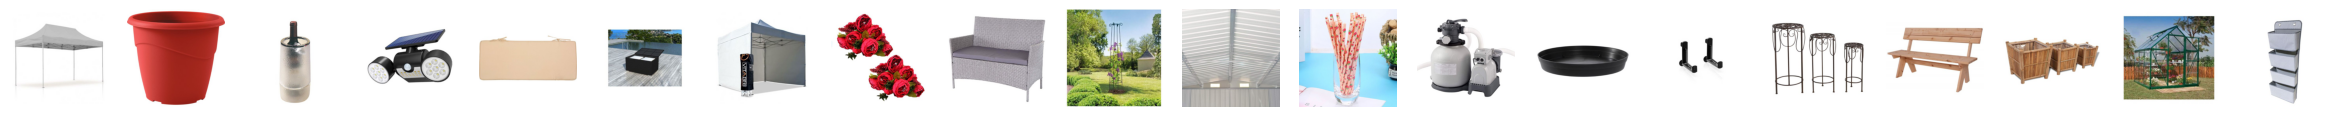

Before cleaning
Top 5 features when designation ['blanc' 'cm' 'gris' 'jardin' 'pvc']
Top 5 features when designation+description ['39' 'br' 'cm' 'li' 'strong']
After cleaning
Top 5 features when designation ['jardin' 'kitchen' 'm²' 'pvc' 'table']
Top 5 features when designation+description ['acier' 'aluminium' 'facile' 'jardin' 'table']
-----------------------------------------------------------------------
First 20 entries for type 2583


designation  \
20     Kit de désinfection pour piscines enfants 20990   
39               Bouée gonflable River tube - OOGARDEN   
53                          Testeur électronique de pH   
58                   Pompe de filtration Speck Badu 95   
64    AstralCom 1 CV Mono de DAB - Surpresseur piscine   
65   Lot de 8 préfiltres jetables pour panier de sk...   
70   Piscine gonflable de pulvérisation Forme Tortu...   
84   Bâche hiver pour piscine Toledo - 280 gr/m² - ...   
90   Idrasoft 5600 SXT - 30 L de marque Idrania - C...   
91   Bâche de piscine bleue rectangulaire en PE 450...   
108  SPA 6 places à bulles ST MORITZ et 2 cartouche...   
116  Augmentateur d'alcalinité 6 kg CTX - 102106 - CTX   
117        Lot De 5 Tés À Coller Pvc Pression Diam. 63   
118  Kit piscine acier aspect pierre Gré Cerdeña ro...   
130     Douche Solaire De Camping Et Voyage 20 L 2 Pcs   
139  Chlore multifonctions waterblue galets 500g - ...   
145                Cartouche pour filtre hayward c1200   
152              Housse d'hivernage Zodiac EDENPAC 1-5   
167      Pompe à chaleur pacfirst steel wifi 8 kw mono   
171  ccei - coffret electrique pour filtration + ba...   

                                           description  prdtypecode  
20                                                 NaN         2583  
39   Bouée gonflable River tube en PVC idéale pour ...         2583  
53   Utilisation du Testeur électronique de pHGrâce...         2583  
58                                                 NaN         2583  
64   Tension (V) : Monophasé - 230 V  Puissance : 1...         2583  
65   Lots de 8 pré-filtres jetables de la marque Ma...         2583  
70   <p>Cette merveilleuse piscine de pulvérisation...         2583  
84   <p>Bâche hiver pour piscine Toledo - 280 g/m² ...         2583  
90   Idrasoft 5600 SXT - 30 L de Idrania - Adouciss...         2583  
91   Cette bâche solaire de piscine repose directem...         2583  
108  Ce SPA gonflable 5-7 places à l&#39;aspect tre...         2583  
116  L&#39; augmentateur d&#39;alcalinité est compo...         2583  
117                                                NaN         2583  
118  Piscine hors-sol en acier aspect pierre Cerdeñ...         2583  
130                                                NaN         2583  
139  Chlore multi-fonction 30 kg en galets de 500 G...         2583  
145  Cartouche pour filtre Star Clear Hayward C250....         2583  
152  Utilisation de la housse d'hivernage Zodiac ED...         2583  
167  La pompe à chaleur PacFirst Steel WIFI 8 kW Mo...         2583  
171  ccei ccei - coffret electrique pour filtration...         2583

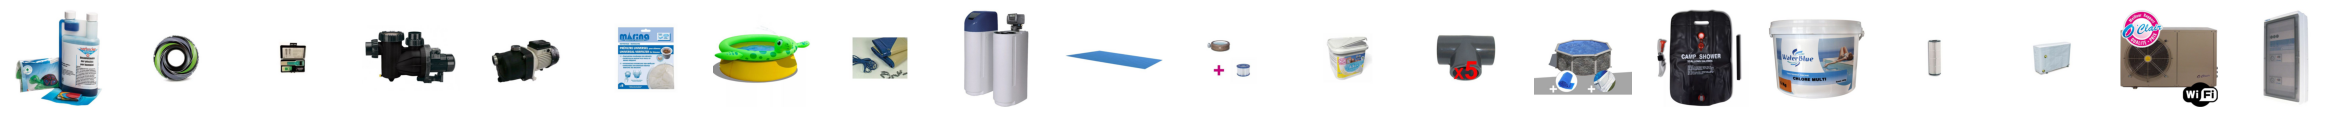

Before cleaning
Top 5 features when designation ['bâche' 'cm' 'kit' 'piscine' 'spa']
Top 5 features when designation+description ['39' 'br' 'li' 'piscine' 'strong']
After cleaning
Top 5 features when designation ['bâche' 'kit' 'piscine' 'pompe' 'spa']
Top 5 features when designation+description ['acier' 'eau' 'filtration' 'piscine' 'pompe']
-----------------------------------------------------------------------
First 20 entries for type 2585


designation  \
162            Tuyau à goutteur incorporé 16 mm x 25 m   
176  Taille-haies sans fil ComfortCut Li-18/60 lvré...   
272  Loft urban pot de fleur rond - 50 cm - bleu vi...   
275  Trou traversant Pince à sertir multifonction E...   
339        C/SEP ARRIERE GHE SUPERCHIEF B737117 AD.IHF   
352  Bâche Camion 640 microns - gris foncé - Longue...   
413        Té pour clarinette d'arrosage enterré 26/34   
429  Duty en métal Tuyau Buse pour pulvérisateur de...   
430  Jardin d'irrigation des plantes d'intérieur Ap...   
468  Travail du bois Recadrage Outils de société Fl...   
470  Électronique 7 pouces 360 degrés Angle numériq...   
492  Kit raccord eau pour Nettoyeur haute pression ...   
509  20 PCS Canette Gardez vos fils de cannette app...   
523  Profondeur de 6 cylindres alésage 5/16" - 6" &...   
536  3pcs durables ronde plus Perforateur Béton Mas...   
541  Spikes en acier inoxydable pour oiseaux pigeon...   
561  Sac aspirateur domestiques - Moulinex Alto par...   
602                 LANCE FRUITIERE 1.50M +RACCORD D10   
629  Chaîne tronçonneuse KERWOOD 56 maillons 3/8" 1...   
665  LIGHTWAVE rampe néons T5 432 W 4 X 8 TUBES CRO...   

                                           description  prdtypecode  
162  Tuyau à goutteur incorporé  Caractéristiques -...         2585  
176  <p><strong>LIVRE SANS BATTERIE NI CHARGEUR</st...         2585  
272                                                NaN         2585  
275  Décapage Artefact Électricien automatique Déca...         2585  
339                                                NaN         2585  
352  <strong>Bâche de type &#34;camion&#34; 640 mic...         2585  
413  Pour connecter et faciliter le montage des éle...         2585  
429  Ce pistolet Spay a également une finition anod...         2585  
430  Jardin d&#39;irrigation des plantes Appareil i...         2585  
468  Travail du bois Recadrage Outils de société Fl...         2585  
470  Électronique 7 pouces de 360 ??degrés d&#39;an...         2585  
492  Kit raccord eau compatible avec  Mac155xtra 13...         2585  
509  20 PCS Canette Gardez vos fils de cannette app...         2585  
523  Vernier numérique Détails :  <br /> <br /> out...         2585  
536  3pcs durables ronde plus MARTEAU Béton Masonar...         2585  
541  Spikes oiseaux en acier inoxydable pour les pi...         2585  
561  <b>Sac aspirateur domestiques - Moulinex Alto ...         2585  
602                                                NaN         2585  
629  Code Sodipièces : 63056Modèle : Chaîne KERWOOD...         2585  
665  LIGHTWAVE T5 4 X 8 néons &#61; 432W TUBES CROI...         2585

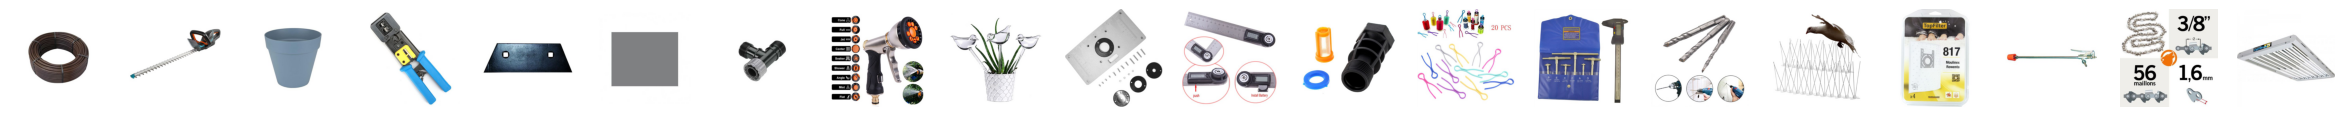

Before cleaning
Top 5 features when designation ['aspirateur' 'longueur' 'mm' 'outil' 'tools']
Top 5 features when designation+description ['39' 'br' 'li' 'strong' 'ul']
After cleaning
Top 5 features when designation ['aspirateur' 'jardin' 'longueur' 'outil' 'tools']
Top 5 features when designation+description ['aspirateur' 'bâche' 'eau' 'haute' 'qualité']
-----------------------------------------------------------------------
First 20 entries for type 2705


designation  \
4                                 La Guerre Des Tuques   
56                 Ne Regardez Pas Le Voleur Qui Passe   
111  Les Crimes Secrets De Napoléon Buonaparte - Fa...   
141  En Écoutant Tolstoï ; Entretiens Sur La Guerre...   
144  Les Révélations Du Crime Ou Cambray Et Ses Com...   
150              La Mer Et Les Marins Scènes Maritimes   
164     L'intégrale Des ¿Uvres De Jules Verne - Tome 3   
197  Mon Premier Amour : Les Chroniques D'un Grand ...   
217                         2001 L'odyssée De L'espace   
221                            Blonde À Forte Poitrine   
244                        Le Meurtrier Du Mois D'août   
262                                     Un Os À Ronger   
322                         Petits Flirts (Entre Amis)   
363                           Un Clou Chassant L'autre   
457                  Les Nouvelles Enquêtes De Maigret   
480                                La Route Du Simplon   
514           Cintia Occupation Double A Changé Ma Vie   
515                     Lettre Sur Le Pouvoir D?Écrire   
525                     La Calligraphie De L'invisible   
528                L'ermitage Du Mont-Cindre Près Lyon   

                                           description  prdtypecode  
4    Luc a des id&eacute;es de grandeur. Il veut or...         2705  
56   Depuis quatre ans le mensuel Marie Claire orga...         2705  
111                                                NaN         2705  
141                                                NaN         2705  
144                                                NaN         2705  
150                                                NaN         2705  
164  <p align=&quot;justify&quot;><b>Tome III</b> :...         2705  
197                                                NaN         2705  
217  Ce livre est né du désir d'explorer en quoi co...         2705  
221  Dernière sélection du Prix de la Closerie des ...         2705  
244                                                NaN         2705  
262  Lorsque la police découvre le cadavre d'une ad...         2705  
322                                                NaN         2705  
363                                                NaN         2705  
457  <p> <b>&quot; Je m'&eacute;tais lev&eacute; &a...         2705  
480                                                NaN         2705  
514                                                NaN         2705  
515  En février 1943 Claude-Edmonde Magny écrit cet...         2705  
525                                                NaN         2705  
528                                                NaN         2705

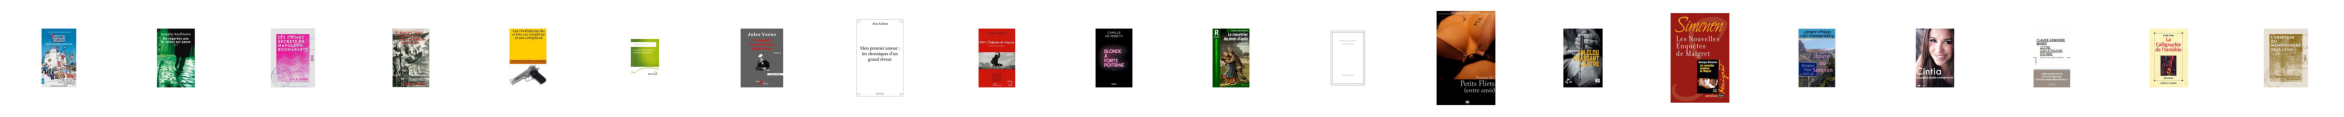

Before cleaning
Top 5 features when designation ['guerre' 'histoire' 'petit' 'tome' 'vie']
Top 5 features when designation+description ['agrave' 'br' 'eacute' 'qu' 'rsquo']
After cleaning
Top 5 features when designation ['guerre' 'histoire' 'petit' 'tome' 'vie']
Top 5 features when designation+description ['agrave' 'eacute' 'egrave' 'qu' 'rsquo']
-----------------------------------------------------------------------
First 20 entries for type 2905


designation  \
148   Motogp 14 - Season Pass (Extension) - Jeu En T...   
287   Snark Busters: High Society - Jeu En Télécharg...   
611   Crusader Kings Ii: Rajas Of India - Dlc - Jeu ...   
653    Rage Against The Zombies - Jeu En Téléchargement   
672            Last Day Of June - Jeu En Téléchargement   
691   Reflections Of Life - L'appel Des Ancêtres - J...   
745   Jagged Alliance 2 Wildfire - Jeu En Télécharge...   
799   Dragon Ball Fighterz - Ultimate Edition - Jeu ...   
1020  Anno 2070 Complete Edition - Jeu En Télécharge...   
1085  Watch Dogs 2 - Mega Pack (Extension Dlc) - Jeu...   
1120             Shadow Warrior - Jeu En Téléchargement   
1124  Europa Universalis Iv: Wealth Of Nations - Exp...   
1132     Guilty Gear Xrd -Sign- - Jeu En Téléchargement   
1171               Virtual Farm - Jeu En Téléchargement   
1222  Through The Woods Collector's Edition - Jeu En...   
1433  Tom Clancy's Rainbow Six Vegas 2 - Jeu En Télé...   
1803  Crusader Kings Ii: Sunset Invasion - Dlc - Jeu...   
1924  Two Worlds Ii - Echoes Of The Dark Past 2 (Ext...   
2207  Warhammer 40000: Dawn Of War Ii: Retribution -...   
2252  Port Royale 3 Gold Edition - Jeu En Télécharge...   

                                            description  prdtypecode  
148   NOTE : Nécessite le jeu original MotoGP 14 pou...         2905  
287   <p>L&#39;amour la jalousie et la vengeance se ...         2905  
611   NOTE : Nécessite le jeu original <b>Crusader K...         2905  
653   NOTE : code d&#39;activation à utiliser exclus...         2905  
672   <div> <p><strong>Note :</strong> code d&#39;ac...         2905  
691   <p>Le jour de ses 21 ans en passant un collier...         2905  
745   NOTE : Code d&#39;activation à utiliser exclus...         2905  
799   <div> <p><strong>NOTE :</strong> Un compte Ste...         2905  
1020  <div> <p><strong>Note :</strong> code d&#39;ac...         2905  
1085  <div> <p> <strong>NOTE :</strong> Nécessite le...         2905  
1120  NOTE : code d&#39;activation à utiliser exclus...         2905  
1124  <div> <p><strong>NOTE :</strong> nécessite le ...         2905  
1132  Revolutionary graphics Overwhelming battle sys...         2905  
1171  Virtual Farm vous charge de transformer une pe...         2905  
1222  NOTE : code d&#39;activation à utiliser exclus...         2905  
1433  <div> <p><strong>NOTE :</strong> un compte Upl...         2905  
1803  NOTE : Nécessite le jeu original Crusader King...         2905  
1924  <div> <p><strong>NOTE :</strong> Nécessite le ...         2905  
2207  NOTE : Nécessite le jeu original Warhammer 400...         2905  
2252  <strong>GOLD EDITION</strong> <hr align='cente...         2905

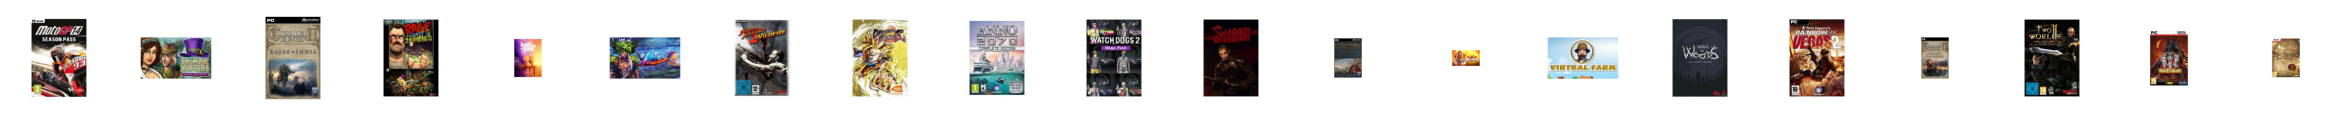

Before cleaning
Top 5 features when designation ['dlc' 'edition' 'extension' 'jeu' 'téléchargement']
Top 5 features when designation+description ['39' 'br' 'li' 'strong' 'ul']
After cleaning
Top 5 features when designation ['dlc' 'edition' 'extension' 'jeu' 'téléchargement']
Top 5 features when designation+description ['gb' 'intel' 'jeu' 'système' 'windows']
-----------------------------------------------------------------------


In [6]:
import re
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop
bytypecode = data.groupby('prdtypecode')
nsamples=20

final_stopwords_list = list(fr_stop) + list(en_stop)
max_features=5
coun_vect1 = CountVectorizer(lowercase=True, stop_words=final_stopwords_list, max_features=max_features)
coun_vect2 = CountVectorizer(lowercase=True, stop_words=final_stopwords_list, max_features=max_features)


for code, frame in bytypecode:
    print(f"First {nsamples} entries for type {code!r}")
    fig, axs = plt.subplots(1, nsamples, figsize=(30, 10))
    frame_samples=frame.head(nsamples)
    display(frame_samples[['designation', 'description', 'prdtypecode']])
    for ax, (index, row) in zip(axs,frame_samples.iterrows()):
        imgid = row['imageid']
        prdid = row['productid']
        img = mpimg.imread(f'{data_images_root_folder}/image_train/image_{imgid}_product_{prdid}.jpg')
        imgplot = ax.imshow(img)
        ax.axis('off')
    plt.show()

    # Text count vectorizer on the product type data frame
    print('Before cleaning')
    count_matrix_desi = coun_vect1.fit_transform(frame['designation'])
    count_matrix_desi_desc = coun_vect2.fit_transform(frame['designation']+frame['description'].fillna(''))
    print(f'Top {max_features} features when designation', coun_vect1.get_feature_names_out())
    print(f'Top {max_features} features when designation+description', coun_vect2.get_feature_names_out())

    
    print('After cleaning')
    to_ignore=['cm','mm','taille','dimensions','hauteur','largeur','couleur','nbsp','comprend','description','import','france','japonais','blanc','gris','noir']
    frame_cleaned=frame.fillna('')\
        .replace(r'<.*?>','', regex=True)\
          .replace(r'\d+','', regex=True)\
            .replace(r'.*Attention !!! Ce produit est un import.*','', regex=True)\
            .replace(re.compile(r'\[Import Allemand\]'),'', regex=True)\
              .replace({f'(?i){word}': '' for word in to_ignore}, regex=True)
    count_matrix_desi = coun_vect1.fit_transform(frame_cleaned['designation'])
    count_matrix_desi_desc = coun_vect2.fit_transform(frame_cleaned['designation']+frame_cleaned['description'])
    print(f'Top {max_features} features when designation', coun_vect1.get_feature_names_out())
    print(f'Top {max_features} features when designation+description', coun_vect2.get_feature_names_out())
    
    print("-----------------------------------------------------------------------")


Combining 'designation' with 'description' seems to give better results in term of identifying the features related to the product type  

Tokens that can be ignored:
* english and french stop words
* ponctuation
* dimension vocab: cm, mm, hauteur, etc
* colors vocab: blanc, girs, etc.
* HTML markdown tags
* numerics
* lemmatization: process of reducing a token to its lemma

From the data assessment above & search made in rakuten website, following product types labels are identified as related to the existing product type codes.

In [7]:
map_prdtypecode_guess={10:'Livres/Livres anciens ?', 
                       40:'Jeux vidéo', 
                       50:'Jeux vidéo/Accessoires', 
                       60:'Consoles', 
                       1140:'Goodies/Figurines', 
                       1160:'Goodies/Cartes de jeux', 
                       1180:'Jouets enfant/occasion ?',
                       1280:'Jouets enfant',
                       1281:'Jouets enfant/occasion ?',
                       1300: 'Modélisme',
                       1301: 'Puériculture',
                       1302: 'Puériculture autre ?',
                       1320: 'Puériculture autre ?',
                       1560: 'Mobilier',
                       1920: 'Coussin Décoratif',
                       1940: 'Alimentation',
                       2060: 'Décoration',
                       2220: 'Aminalerie',
                       2280: 'Revues et magazines anciens',
                       2403: 'Lots de Livres et de Revues',
                       2462: 'Lots de consoles et jeux vidéo',
                       2522: 'Fournitures Papeterie',
                       2582: 'Mobilier de Jardin',
                       2583: 'Entretien piscine & spa',
                       2585: 'Outillage de jardin',
                       2705: 'Livres/Littérature',
                       2905: 'Jeux Vidéo/PC'}
data_prdtypecode_label_guess =pd.DataFrame.from_dict(map_prdtypecode_guess, orient = 'index', columns=['prdtypelabelguess'])

## Text data preprocessing

In [56]:
import string
import spacy
from pandas import option_context

data_cleaned = data.fillna('')
data_cleaned["desi_desc"]=data_cleaned["designation"].str.cat(data_cleaned["description"], sep = " ")
#nlpen = spacy.load('en_core_web_sm',)
nlpfr = spacy.load('fr_core_news_sm')
to_ignore=['cm','mm','taille','dimensions','hauteur','largeur','couleur','nbsp','comprend','description','import','france','japonais','anglais','blanc','gris','noir']

def cleaner(x):
    c= re.sub(r'.*Attention !!! Ce produit est un import.*', '', x)
    c= re.sub(re.compile(r'\[Import Allemand\]'), '', c)
    c= re.sub(re.compile(r'\b(?:{})\b'.format('|'.join(map(re.escape, to_ignore)))), '', c)
    c= re.sub(re.compile(r'\b(?:{})\b'.format('|'.join(map(re.escape, nlpfr.Defaults.stop_words)))), '', c)
    c= re.sub(r'<.*?>', '', c)
    c= re.sub('[%s]' % re.escape(string.punctuation), '', c)
    c= re.sub(r'\d', '', c)
    c=' '.join([word for word in c.split() if len(word) >=3])
    c = c.lower()
    #ignored as takes time consuming
    #c=' '.join([token.lemma_ for token in list(nlpfr(c)) if (token.is_stop==False)])
    return c

data_cleaned["desi_desc"] = data_cleaned["desi_desc"].apply(lambda x:cleaner(x))
with option_context('display.max_colwidth', 400):
  display(data_cleaned[["desi_desc","designation","description"]])

UnboundLocalError: cannot access local variable 'c' where it is not associated with a value

In [54]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Drop unneeded columns

In [ ]:
data_cleaned=data_cleaned.drop(['designation','description','desi_desc'], axis=1)

In [9]:
display(data_cleaned)

productid     imageid  prdtypecode  \
0      3804725264  1263597046           10   
1       436067568  1008141237         2280   
2       201115110   938777978           50   
3        50418756   457047496         1280   
4       278535884  1077757786         2705   
...           ...         ...          ...   
84911   206719094   941495734           40   
84912  3065095706  1188462883         2583   
84913   440707564  1009325617         2280   
84914  3942400296  1267353403         1560   
84915    57203227   684671297         2522   

                                               desi_desc  
0      olivia personalisiertes notizbuch   seiten  pu...  
1      journal des arts le n°  du   lart et son march...  
2      grand stylet ergonomique bleu gamepad nintendo...  
3      peluche donald  europe  disneyland  marionnett...  
4      la guerre des tuques luc a des ideacutees de g...  
...                                                  ...  
84911                                      the sims       
84912  kit piscine acier nevada déco pierre ø m x m  ...  
84913  journal officiel de la republique francaise n°...  
84914  table basse bois de récupération massif base h...  
84915  goe de collection  goes pinguin glace vert ora...  

[84916 rows x 4 columns]

In [10]:
data_cleaned_with_prdtypelabel_guess=pd.merge(left=data_cleaned, left_on='prdtypecode', right=data_prdtypecode_label_guess, right_index=True )
display(data_cleaned_with_prdtypelabel_guess)

productid     imageid  prdtypecode  \
0      3804725264  1263597046           10   
1       436067568  1008141237         2280   
2       201115110   938777978           50   
3        50418756   457047496         1280   
4       278535884  1077757786         2705   
...           ...         ...          ...   
84911   206719094   941495734           40   
84912  3065095706  1188462883         2583   
84913   440707564  1009325617         2280   
84914  3942400296  1267353403         1560   
84915    57203227   684671297         2522   

                                               desi_desc  \
0      olivia personalisiertes notizbuch   seiten  pu...   
1      journal des arts le n°  du   lart et son march...   
2      grand stylet ergonomique bleu gamepad nintendo...   
3      peluche donald  europe  disneyland  marionnett...   
4      la guerre des tuques luc a des ideacutees de g...   
...                                                  ...   
84911                                      the sims        
84912  kit piscine acier nevada déco pierre ø m x m  ...   
84913  journal officiel de la republique francaise n°...   
84914  table basse bois de récupération massif base h...   
84915  goe de collection  goes pinguin glace vert ora...   

                 prdtypelabelguess  
0          Livres/Livres anciens ?  
1      Revues et magazines anciens  
2           Jeux vidéo/Accessoires  
3                    Jouets enfant  
4               Livres/Littérature  
...                            ...  
84911                   Jeux vidéo  
84912      Entretien piscine & spa  
84913  Revues et magazines anciens  
84914                     Mobilier  
84915        Fournitures Papeterie  

[84916 rows x 5 columns]

Drop useless columns

In [11]:
X=data_cleaned['desi_desc']
Y=data_cleaned['prdtypecode']


## Text data exploration

<Axes: >

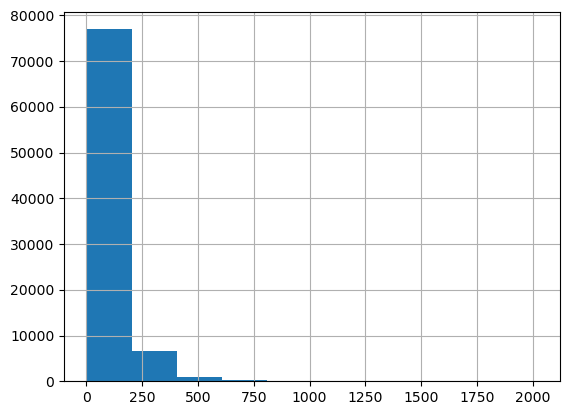

In [12]:
data_cleaned['desi_desc'].str.split().map(lambda x: len(x)).hist()

'designation' range from 10 to 250 characters and generally, it is between 75 to 100 characters

<Axes: >

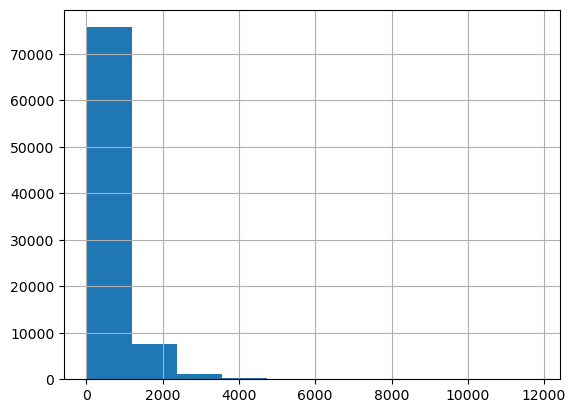

In [13]:
data_cleaned['desi_desc'].str.len().hist()

Number of words in designation ranges from 3 to 50 and mostly falls between 3 to 18 words.

<Axes: >

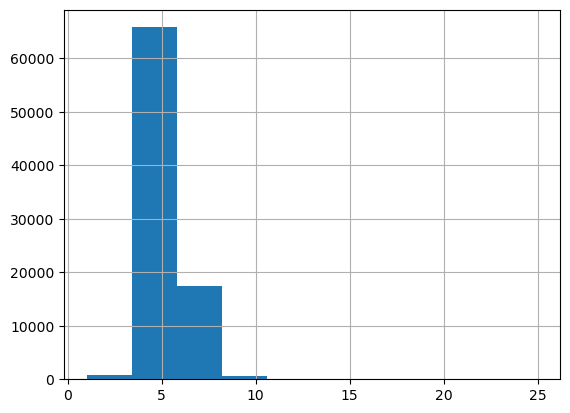

In [14]:
data_cleaned['desi_desc'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

The average word length ranges between 2 to 8 with 5 being the most common length

### Features extraction

# Training

## Naive Bayes

## Support Vector Machine (SVM)